In [ ]:
import os, requests, zipfile, random

import torch
# from nnsight.models.UnifiedTransformer import UnifiedTransformer
import clip
import nnsight
import overcomplete

import datasets
from pycocotools.coco import COCO

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec

import hashlib

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [19]:
model, preprocess = clip.load("ViT-B/32", device=device)
model = model.to(dtype=torch.float32)
print(f"Loaded CLIP model: {model.__class__.__name__}")
print(f"Model device: {device}")
print(f"Model dtype: {model.dtype}")

Loaded CLIP model: CLIP
Model device: cuda
Model dtype: torch.float32


In [20]:
# Load COCO annotations
annFile = '/datasets/shared_datasets/coco/annotations/captions_train2017.json'
coco = COCO(annFile)

# Image directory
image_dir = '/datasets/shared_datasets/coco/train2017'

# Prepare image-caption pairs
data = []
for img_id in coco.getImgIds():
    img_info = coco.loadImgs(img_id)[0]
    file_path = os.path.join(image_dir, img_info['file_name'])
    captions = [ann['caption'] for ann in coco.loadAnns(coco.getAnnIds(imgIds=img_id))]
    for caption in captions:
        data.append((file_path, caption))

@torch.no_grad()
def extract_activations(model, image, text, normalize=True):
    # Extract image and text features
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)

    # Normalize features
    if normalize:
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    return image_features, text_features

class CocoCaptionDataset(torch.utils.data.Dataset):
    def __init__(self, data, preprocess, tokenizer):
        self.data = data
        self.preprocess = preprocess
        self.tokenizer = tokenizer
        self.cache_dir = "./coco/activations"
        os.makedirs(self.cache_dir, exist_ok=True)

    def __len__(self):
        return len(self.data)

    def _get_cache_path(self, img_path, caption):
        key = hashlib.md5((img_path + caption).encode()).hexdigest()
        return os.path.join(self.cache_dir, f"{key}.pt")

    def __getitem__(self, idx):
        img_path, caption = self.data[idx]
        cache_path = self._get_cache_path(img_path, caption)

        if os.path.exists(cache_path):
            image_features, text_features = torch.load(cache_path)
        else:
            image = self.preprocess(Image.open(img_path)).to(device).unsqueeze(0)
            text = self.tokenizer([caption])[0].to(device).unsqueeze(0)
            image_features, text_features = extract_activations(model, image, text)
            torch.save((image_features, text_features), cache_path)

        return image_features.squeeze(0), text_features.squeeze(0)

coco_dataset = CocoCaptionDataset(data, preprocess, clip.tokenize)

loading annotations into memory...
Done (t=0.47s)
creating index...
index created!


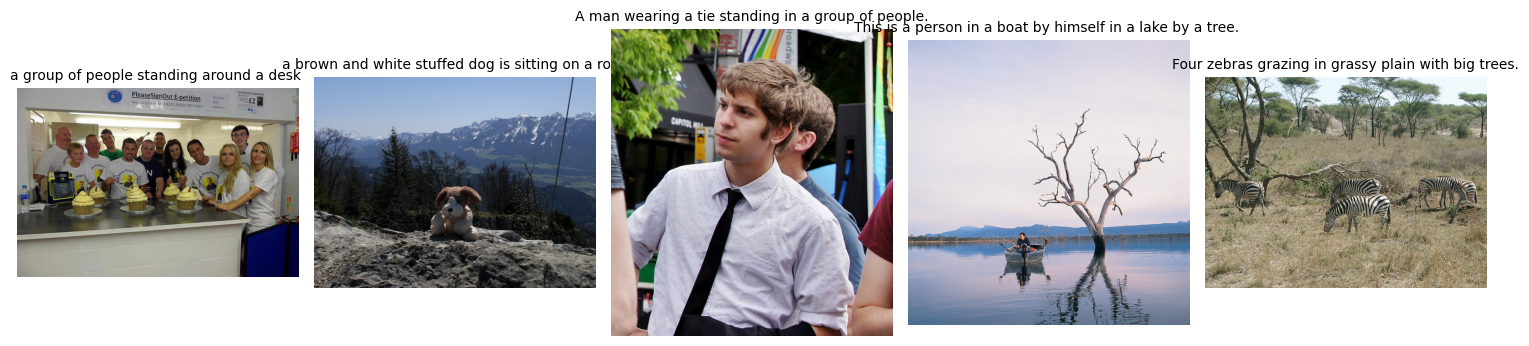

In [21]:
# Display a few images with captions
def plot_images_with_captions(data, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    axes = axes.flatten()

    # Select random images
    for i in range(num_images):
        img_path, caption = random.choice(data)
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(caption, fontsize=10)

    plt.tight_layout()
    plt.show()

# Plot random images with captions
plot_images_with_captions(data)

In [22]:
N = 10  # Number of images to sample
random.seed(42)
shuffled_data = data.copy()
random.shuffle(shuffled_data)
sampled_data = shuffled_data[:N]

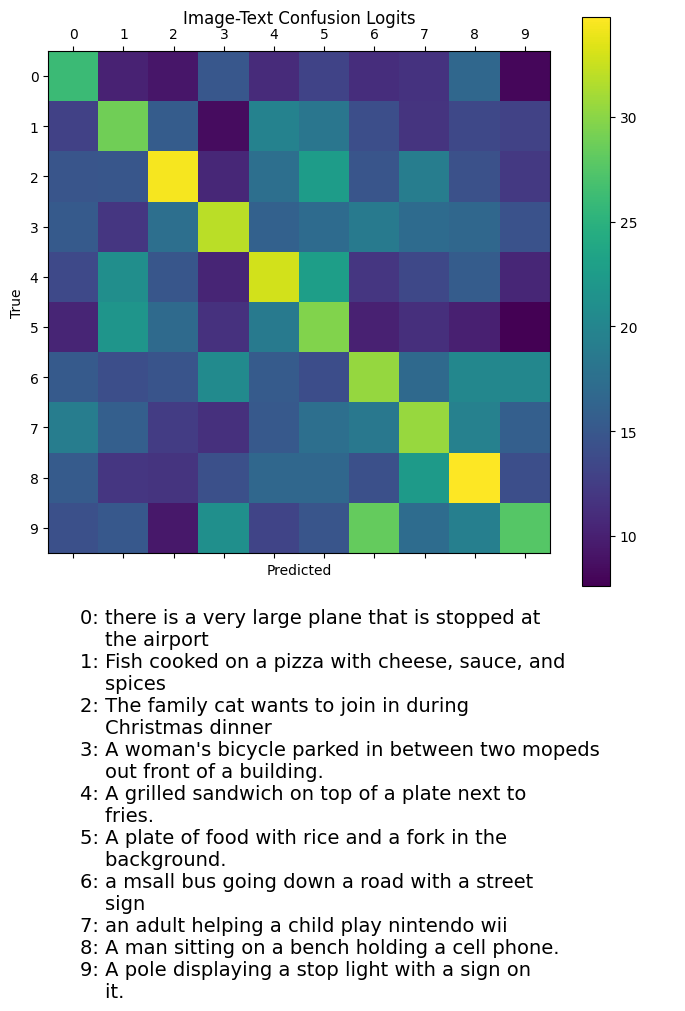

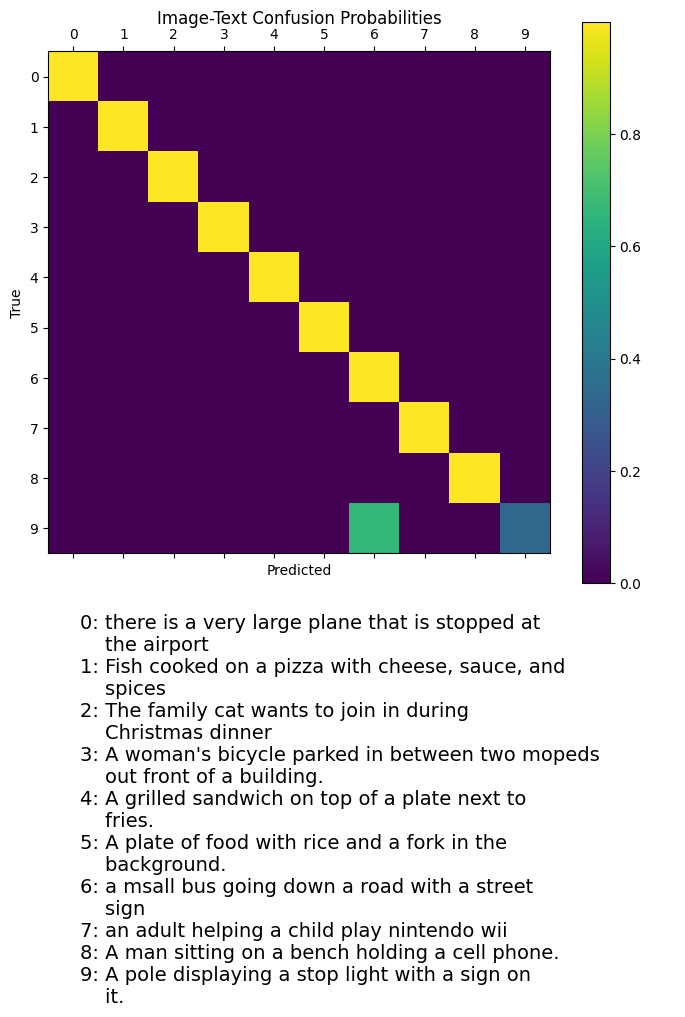

In [23]:
image = torch.stack([preprocess(Image.open(img_path)) for img_path, _ in sampled_data]).to(device)
text = clip.tokenize([caption for _, caption in sampled_data]).to(device)

with torch.no_grad():    
    image_logits, text_logits = model(image, text)
    image_probs = image_logits.softmax(dim=-1).cpu().numpy()
    text_probs = text_logits.softmax(dim=-1).cpu().numpy()
"""
    # # create my own cosim matrix from image and text features
    
    # image_features = model.encode_image(image) # Shape: (10, 512)
    # text_features = model.encode_text(text) # Shape: (10, 512)

    # image_features_reduced = torch.zeros_like(image_features)
    # image_features_reduced[0] = image_features[:5, :].mean(dim=0)
    # image_features_reduced[1] = image_features[5:, :].mean(dim=0)

    # text_features_reduced = torch.zeros_like(text_features)
    # text_features_reduced[0] = text_features[:5, :].mean(dim=0)
    # text_features_reduced[1] = text_features[5:, :].mean(dim=0)

    # image_features /= image_features.norm(dim=-1, keepdim=True)
    # image_features_reduced /= image_features_reduced.norm(dim=-1, keepdim=True)

    # text_features /= text_features.norm(dim=-1, keepdim=True)
    # text_features_reduced /= text_features_reduced.norm(dim=-1, keepdim=True)

    # cosim_matrix = image_features @ text_features.T  # Shape: (10, 10)
    # cosim_matrix_reduced = image_features_reduced @ text_features_reduced.T  # Shape: (2, 2)
    # cosim_probs = cosim_matrix.softmax(dim=-1).cpu().numpy()
    # cosim_probs_reduced = cosim_matrix_reduced.softmax(dim=-1).cpu().numpy()
"""


# Break long captions into multiple lines
def linebreak(text, max_line_length):
    words = text.split(" ")  # Split the text into words
    lines = []
    current_line = []

    for word in words:
        # Check if adding this word exceeds max_line_length
        if len(" ".join(current_line + [word])) <= max_line_length:
            current_line.append(word)
        else:
            # If it exceeds, push the current line and start a new one
            lines.append(" ".join(current_line))
            current_line = [word]
    
    # Append the last line
    if current_line:
        lines.append(" ".join(current_line))

    return "\n    ".join(lines)

# Plot both confusion matrices :
def plot_confusion_matrix(data, probs, title):
    n = len(data)
    captions = [f"{i}: {caption}" for i, (_, caption) in enumerate(data)]
    
    max_line_length = 50  # Maximum characters per line
    wrapped_captions = []
    for caption in captions:
        # Break each caption into multiple lines
        wrapped_captions.append(linebreak(caption, max_line_length))

    # Join all wrapped captions
    legend_text = "\n".join(wrapped_captions)

    fig = plt.figure(figsize=(7, 10))
    gs = GridSpec(2, 1, height_ratios=[10, 1])

    ax_matrix = fig.add_subplot(gs[0])
    cax = ax_matrix.matshow(probs, cmap='viridis')
    fig.colorbar(cax, ax=ax_matrix)

    ax_matrix.set_xticks(range(n))
    ax_matrix.set_yticks(range(n))
    ax_matrix.set_xticklabels(range(n))
    ax_matrix.set_yticklabels(range(n))

    ax_matrix.set_title(title, pad=20)
    ax_matrix.set_xlabel('Predicted')
    ax_matrix.set_ylabel('True')

    # Legend below
    ax_legend = fig.add_subplot(gs[1])
    ax_legend.axis("off")
    ax_legend.text(0.05, 2, legend_text, fontsize=14, va='center', ha='left', wrap=True)

    plt.tight_layout()
    plt.show()
    
plot_confusion_matrix(sampled_data, image_logits.cpu().detach(), "Image-Text Confusion Logits")
plot_confusion_matrix(sampled_data, image_probs, "Image-Text Confusion Probabilities")

In [33]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(coco_dataset, batch_size=batch_size, shuffle=True)#, num_workers=0)

In [ ]:
import importlib
import overcomplete
importlib.reload(overcomplete.sae.modules)
importlib.reload(overcomplete.sae.train)
importlib.reload(overcomplete.sae.losses)

top_k_individual = 50 * 2

d_model = 512 # image_features.shape[-1] # 512 for CLIP ViT-B/32

nb_concepts = d_model * 32

sae = overcomplete.sae.BatchTopKSAE(d_model, nb_concepts=nb_concepts, top_k=top_k_individual*batch_size, device=device)
sae.to(device)
sae.train()

alpha = 0.1  # Dead features loss penalty
beta = 0.001  # Alignment penalty

optimizer = torch.optim.Adam(sae.parameters(), lr=5e-4)
criterion_1 = lambda *args, **kwargs: overcomplete.sae.losses.top_k_auxiliary_loss(*args, **kwargs, penalty=alpha)
criterion_2 = lambda *args, **kwargs: overcomplete.sae.losses.alignment_penalty(*args, **kwargs, penalty=beta)

criterion = lambda *args, **kwargs: criterion_1(*args, **kwargs) + criterion_2(*args, **kwargs)

logs = overcomplete.sae.train.train_multimodal_sae(sae, train_loader, criterion, optimizer, nb_epochs=30, device=device, verbose=True, checkpoint_path=None, checkpoint_interval=5, checkpoint_name="coco_batchtopk_32.pt")

Epoch 1/30:   0%|          | 0/2312 [00:00<?, ?it/s]

Epoch 1/30:   0%|          | 1/2312 [00:05<3:35:23,  5.59s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005601344746537507
Epoch[1/30], Batch[1], Loss: 0.0051, R2: -0.5033, L0: 50.0000, Dead Features: 82.7%
Batch[1], Time taken to get the batch: 5.5712 seconds
Batch[1], Time taken to process the batch: 0.0216 seconds


Epoch 1/30:   0%|          | 2/2312 [00:11<3:38:04,  5.66s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005545906024053693
Epoch[1/30], Batch[2], Loss: 0.0038, R2: -0.4443, L0: 50.0000, Dead Features: 78.8%
Batch[2], Time taken to get the batch: 5.6908 seconds
Batch[2], Time taken to process the batch: 0.0241 seconds


Epoch 1/30:   0%|          | 3/2312 [00:17<3:39:34,  5.71s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005453418707475066
Epoch[1/30], Batch[3], Loss: 0.0037, R2: -0.3842, L0: 50.0000, Dead Features: 76.2%
Batch[3], Time taken to get the batch: 5.7369 seconds
Batch[3], Time taken to process the batch: 0.0183 seconds


Epoch 1/30:   0%|          | 4/2312 [00:22<3:36:29,  5.63s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005392563762143254
Epoch[1/30], Batch[4], Loss: 0.0037, R2: -0.3490, L0: 50.0000, Dead Features: 74.0%
Batch[4], Time taken to get the batch: 5.4879 seconds
Batch[4], Time taken to process the batch: 0.0208 seconds


Epoch 1/30:   0%|          | 5/2312 [00:28<3:34:22,  5.58s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005333154113031924
Epoch[1/30], Batch[5], Loss: 0.0034, R2: -0.3111, L0: 50.0000, Dead Features: 72.5%
Batch[5], Time taken to get the batch: 5.4608 seconds
Batch[5], Time taken to process the batch: 0.0209 seconds


Epoch 1/30:   0%|          | 6/2312 [00:33<3:35:44,  5.61s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005244314670562744
Epoch[1/30], Batch[6], Loss: 0.0031, R2: -0.2811, L0: 50.0000, Dead Features: 71.2%
Batch[6], Time taken to get the batch: 5.6674 seconds
Batch[6], Time taken to process the batch: 0.0205 seconds


Epoch 1/30:   0%|          | 7/2312 [00:39<3:35:12,  5.60s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005155746475793421
Epoch[1/30], Batch[7], Loss: 0.0030, R2: -0.2635, L0: 50.0000, Dead Features: 70.0%
Batch[7], Time taken to get the batch: 5.5569 seconds
Batch[7], Time taken to process the batch: 0.0211 seconds


Epoch 1/30:   0%|          | 8/2312 [00:44<3:33:49,  5.57s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005067808087915182
Epoch[1/30], Batch[8], Loss: 0.0029, R2: -0.2457, L0: 50.0000, Dead Features: 68.8%
Batch[8], Time taken to get the batch: 5.4784 seconds
Batch[8], Time taken to process the batch: 0.0181 seconds


Epoch 1/30:   0%|          | 9/2312 [00:50<3:32:28,  5.54s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005028870073147118
Epoch[1/30], Batch[9], Loss: 0.0029, R2: -0.2384, L0: 50.0000, Dead Features: 67.7%
Batch[9], Time taken to get the batch: 5.4457 seconds
Batch[9], Time taken to process the batch: 0.0185 seconds


Epoch 1/30:   0%|          | 10/2312 [00:55<3:31:32,  5.51s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0004954520845785737
Epoch[1/30], Batch[10], Loss: 0.0029, R2: -0.2263, L0: 50.0000, Dead Features: 66.6%
Batch[10], Time taken to get the batch: 5.4443 seconds
Batch[10], Time taken to process the batch: 0.0195 seconds


Epoch 1/30:   0%|          | 11/2312 [01:01<3:30:47,  5.50s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0004918600898236036
Epoch[1/30], Batch[11], Loss: 0.0028, R2: -0.2204, L0: 50.0000, Dead Features: 65.6%
Batch[11], Time taken to get the batch: 5.4393 seconds
Batch[11], Time taken to process the batch: 0.0185 seconds


Epoch 1/30:   1%|          | 12/2312 [01:07<3:34:21,  5.59s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.00048415918718092144
Epoch[1/30], Batch[12], Loss: 0.0027, R2: -0.2056, L0: 50.0000, Dead Features: 64.7%
Batch[12], Time taken to get the batch: 5.7920 seconds
Batch[12], Time taken to process the batch: 0.0184 seconds


Epoch 1/30:   1%|          | 13/2312 [01:12<3:37:22,  5.67s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0004797923902515322
Epoch[1/30], Batch[13], Loss: 0.0027, R2: -0.1952, L0: 50.0000, Dead Features: 63.9%
Batch[13], Time taken to get the batch: 5.8406 seconds
Batch[13], Time taken to process the batch: 0.0192 seconds


Epoch 1/30:   1%|          | 14/2312 [01:18<3:35:56,  5.64s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.00047383573837578297
Epoch[1/30], Batch[14], Loss: 0.0026, R2: -0.1794, L0: 50.0000, Dead Features: 63.0%
Batch[14], Time taken to get the batch: 5.5376 seconds
Batch[14], Time taken to process the batch: 0.0194 seconds


Epoch 1/30:   1%|          | 15/2312 [01:24<3:35:46,  5.64s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0004682122089434415
Epoch[1/30], Batch[15], Loss: 0.0025, R2: -0.1610, L0: 50.0000, Dead Features: 62.2%
Batch[15], Time taken to get the batch: 5.6129 seconds
Batch[15], Time taken to process the batch: 0.0192 seconds


Epoch 1/30:   1%|          | 16/2312 [01:29<3:35:01,  5.62s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0004645590088330209
Epoch[1/30], Batch[16], Loss: 0.0025, R2: -0.1535, L0: 50.0000, Dead Features: 61.4%
Batch[16], Time taken to get the batch: 5.5614 seconds
Batch[16], Time taken to process the batch: 0.0182 seconds


Epoch 1/30:   1%|          | 17/2312 [01:35<3:35:30,  5.63s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.00045931647764518857
Epoch[1/30], Batch[17], Loss: 0.0025, R2: -0.1415, L0: 50.0000, Dead Features: 60.7%
Batch[17], Time taken to get the batch: 5.6507 seconds
Batch[17], Time taken to process the batch: 0.0184 seconds


Epoch 1/30:   1%|          | 18/2312 [01:41<3:38:21,  5.71s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0004552637110464275
Epoch[1/30], Batch[18], Loss: 0.0024, R2: -0.1247, L0: 50.0000, Dead Features: 60.0%
Batch[18], Time taken to get the batch: 5.8729 seconds
Batch[18], Time taken to process the batch: 0.0181 seconds


Epoch 1/30:   1%|          | 19/2312 [01:47<3:40:58,  5.78s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0004493376472964883
Epoch[1/30], Batch[19], Loss: 0.0024, R2: -0.1055, L0: 50.0000, Dead Features: 59.5%
Batch[19], Time taken to get the batch: 5.9254 seconds
Batch[19], Time taken to process the batch: 0.0216 seconds


Epoch 1/30:   1%|          | 20/2312 [01:52<3:38:40,  5.72s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0004441712808329612
Epoch[1/30], Batch[20], Loss: 0.0024, R2: -0.0983, L0: 50.0000, Dead Features: 58.9%
Batch[20], Time taken to get the batch: 5.5707 seconds
Batch[20], Time taken to process the batch: 0.0194 seconds


Epoch 1/30:   1%|          | 21/2312 [01:58<3:36:31,  5.67s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.00044025082024745643
Epoch[1/30], Batch[21], Loss: 0.0023, R2: -0.0841, L0: 50.0000, Dead Features: 58.5%
Batch[21], Time taken to get the batch: 5.5270 seconds
Batch[21], Time taken to process the batch: 0.0180 seconds


Epoch 1/30:   1%|          | 22/2312 [02:03<3:34:23,  5.62s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0004394151910673827
Epoch[1/30], Batch[22], Loss: 0.0023, R2: -0.0826, L0: 50.0000, Dead Features: 57.9%
Batch[22], Time taken to get the batch: 5.4720 seconds
Batch[22], Time taken to process the batch: 0.0209 seconds


Epoch 1/30:   1%|          | 23/2312 [02:09<3:33:28,  5.60s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0004326816997490823
Epoch[1/30], Batch[23], Loss: 0.0023, R2: -0.0640, L0: 50.0000, Dead Features: 57.5%
Batch[23], Time taken to get the batch: 5.5268 seconds
Batch[23], Time taken to process the batch: 0.0190 seconds


Epoch 1/30:   1%|          | 24/2312 [02:14<3:31:56,  5.56s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.00042907558963634074
Epoch[1/30], Batch[24], Loss: 0.0022, R2: -0.0601, L0: 50.0000, Dead Features: 56.8%
Batch[24], Time taken to get the batch: 5.4480 seconds
Batch[24], Time taken to process the batch: 0.0218 seconds


Epoch 1/30:   1%|          | 25/2312 [02:20<3:30:38,  5.53s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.00042800293886102736
Epoch[1/30], Batch[25], Loss: 0.0022, R2: -0.0545, L0: 50.0000, Dead Features: 56.4%
Batch[25], Time taken to get the batch: 5.4349 seconds
Batch[25], Time taken to process the batch: 0.0168 seconds


Epoch 1/30:   1%|          | 26/2312 [02:25<3:30:03,  5.51s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0004234297084622085
Epoch[1/30], Batch[26], Loss: 0.0022, R2: -0.0462, L0: 50.0000, Dead Features: 55.8%
Batch[26], Time taken to get the batch: 5.4630 seconds
Batch[26], Time taken to process the batch: 0.0201 seconds


Epoch 1/30:   1%|          | 27/2312 [02:31<3:29:10,  5.49s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.00042032625060528517
Epoch[1/30], Batch[27], Loss: 0.0022, R2: -0.0305, L0: 50.0000, Dead Features: 55.2%
Batch[27], Time taken to get the batch: 5.4258 seconds
Batch[27], Time taken to process the batch: 0.0182 seconds


Epoch 1/30:   1%|          | 28/2312 [02:36<3:31:08,  5.55s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0004163769190199673
Epoch[1/30], Batch[28], Loss: 0.0021, R2: -0.0231, L0: 50.0000, Dead Features: 54.8%
Batch[28], Time taken to get the batch: 5.6550 seconds
Batch[28], Time taken to process the batch: 0.0183 seconds


Epoch 1/30:   1%|▏         | 29/2312 [02:42<3:32:16,  5.58s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.000414389418438077
Epoch[1/30], Batch[29], Loss: 0.0021, R2: -0.0164, L0: 50.0000, Dead Features: 54.2%
Batch[29], Time taken to get the batch: 5.6361 seconds
Batch[29], Time taken to process the batch: 0.0183 seconds


Epoch 1/30:   1%|▏         | 30/2312 [02:47<3:30:34,  5.54s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.00041210485505871475
Epoch[1/30], Batch[30], Loss: 0.0021, R2: -0.0018, L0: 50.0000, Dead Features: 53.7%
Batch[30], Time taken to get the batch: 5.4168 seconds
Batch[30], Time taken to process the batch: 0.0214 seconds


Epoch 1/30:   1%|▏         | 31/2312 [02:53<3:29:26,  5.51s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0004105551342945546
Epoch[1/30], Batch[31], Loss: 0.0021, R2: 0.0082, L0: 50.0000, Dead Features: 53.3%
Batch[31], Time taken to get the batch: 5.4265 seconds
Batch[31], Time taken to process the batch: 0.0181 seconds


Epoch 1/30:   1%|▏         | 32/2312 [02:59<3:31:04,  5.55s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0004067072586622089
Epoch[1/30], Batch[32], Loss: 0.0020, R2: 0.0248, L0: 50.0000, Dead Features: 52.9%
Batch[32], Time taken to get the batch: 5.6427 seconds
Batch[32], Time taken to process the batch: 0.0188 seconds


Epoch 1/30:   1%|▏         | 33/2312 [03:04<3:30:31,  5.54s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.00040607911068946123
Epoch[1/30], Batch[33], Loss: 0.0020, R2: 0.0349, L0: 50.0000, Dead Features: 52.4%
Batch[33], Time taken to get the batch: 5.4964 seconds
Batch[33], Time taken to process the batch: 0.0180 seconds


Epoch 1/30:   1%|▏         | 34/2312 [03:10<3:31:47,  5.58s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.000402122619561851
Epoch[1/30], Batch[34], Loss: 0.0020, R2: 0.0474, L0: 50.0000, Dead Features: 51.9%
Batch[34], Time taken to get the batch: 5.6416 seconds
Batch[34], Time taken to process the batch: 0.0194 seconds


Epoch 1/30:   2%|▏         | 35/2312 [03:15<3:32:55,  5.61s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0004022437788080424
Epoch[1/30], Batch[35], Loss: 0.0020, R2: 0.0597, L0: 50.0000, Dead Features: 51.5%
Batch[35], Time taken to get the batch: 5.6662 seconds
Batch[35], Time taken to process the batch: 0.0208 seconds


Epoch 1/30:   2%|▏         | 36/2312 [03:21<3:33:21,  5.62s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.00040355982491746545
Epoch[1/30], Batch[36], Loss: 0.0019, R2: 0.0738, L0: 50.0000, Dead Features: 51.1%
Batch[36], Time taken to get the batch: 5.6388 seconds
Batch[36], Time taken to process the batch: 0.0181 seconds


Epoch 1/30:   2%|▏         | 37/2312 [03:27<3:33:41,  5.64s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0004017732571810484
Epoch[1/30], Batch[37], Loss: 0.0019, R2: 0.0884, L0: 50.0000, Dead Features: 50.8%
Batch[37], Time taken to get the batch: 5.6429 seconds
Batch[37], Time taken to process the batch: 0.0185 seconds


Epoch 1/30:   2%|▏         | 38/2312 [03:32<3:34:13,  5.65s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.00040048680966719985
Epoch[1/30], Batch[38], Loss: 0.0019, R2: 0.1031, L0: 50.0000, Dead Features: 50.3%
Batch[38], Time taken to get the batch: 5.6702 seconds
Batch[38], Time taken to process the batch: 0.0211 seconds


Epoch 1/30:   2%|▏         | 39/2312 [03:38<3:38:44,  5.77s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.00040152756264433265
Epoch[1/30], Batch[39], Loss: 0.0018, R2: 0.1180, L0: 50.0000, Dead Features: 50.0%
Batch[39], Time taken to get the batch: 6.0383 seconds
Batch[39], Time taken to process the batch: 0.0204 seconds


Epoch 1/30:   2%|▏         | 40/2312 [03:44<3:41:29,  5.85s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0003996830200776458
Epoch[1/30], Batch[40], Loss: 0.0018, R2: 0.1333, L0: 50.0000, Dead Features: 49.7%
Batch[40], Time taken to get the batch: 6.0025 seconds
Batch[40], Time taken to process the batch: 0.0212 seconds


Epoch 1/30:   2%|▏         | 41/2312 [03:51<3:44:00,  5.92s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0003979442408308387
Epoch[1/30], Batch[41], Loss: 0.0018, R2: 0.1430, L0: 50.0000, Dead Features: 49.3%
Batch[41], Time taken to get the batch: 6.0615 seconds
Batch[41], Time taken to process the batch: 0.0185 seconds


Epoch 1/30:   2%|▏         | 42/2312 [03:57<3:45:09,  5.95s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.00039862265111878514
Epoch[1/30], Batch[42], Loss: 0.0018, R2: 0.1557, L0: 50.0000, Dead Features: 49.0%
Batch[42], Time taken to get the batch: 6.0092 seconds
Batch[42], Time taken to process the batch: 0.0186 seconds


Epoch 1/30:   2%|▏         | 43/2312 [04:03<3:45:23,  5.96s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.00039983598981052637
Epoch[1/30], Batch[43], Loss: 0.0017, R2: 0.1637, L0: 50.0000, Dead Features: 48.7%
Batch[43], Time taken to get the batch: 5.9633 seconds
Batch[43], Time taken to process the batch: 0.0179 seconds


Epoch 1/30:   2%|▏         | 44/2312 [04:08<3:42:27,  5.89s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.00040056565194390714
Epoch[1/30], Batch[44], Loss: 0.0017, R2: 0.1852, L0: 50.0000, Dead Features: 48.3%
Batch[44], Time taken to get the batch: 5.6924 seconds
Batch[44], Time taken to process the batch: 0.0180 seconds


Epoch 1/30:   2%|▏         | 45/2312 [04:14<3:38:27,  5.78s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.00040303354035131633
Epoch[1/30], Batch[45], Loss: 0.0016, R2: 0.2027, L0: 50.0000, Dead Features: 48.1%
Batch[45], Time taken to get the batch: 5.5200 seconds
Batch[45], Time taken to process the batch: 0.0208 seconds


Epoch 1/30:   2%|▏         | 46/2312 [04:19<3:35:16,  5.70s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0004026605165563524
Epoch[1/30], Batch[46], Loss: 0.0016, R2: 0.2077, L0: 50.0000, Dead Features: 47.8%
Batch[46], Time taken to get the batch: 5.4888 seconds
Batch[46], Time taken to process the batch: 0.0198 seconds


Epoch 1/30:   2%|▏         | 47/2312 [04:25<3:33:04,  5.64s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.00040363945299759507
Epoch[1/30], Batch[47], Loss: 0.0016, R2: 0.2261, L0: 50.0000, Dead Features: 47.6%
Batch[47], Time taken to get the batch: 5.4975 seconds
Batch[47], Time taken to process the batch: 0.0177 seconds


Epoch 1/30:   2%|▏         | 48/2312 [04:31<3:34:25,  5.68s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.00040787371108308434
Epoch[1/30], Batch[48], Loss: 0.0016, R2: 0.2314, L0: 50.0000, Dead Features: 47.3%
Batch[48], Time taken to get the batch: 5.7533 seconds
Batch[48], Time taken to process the batch: 0.0185 seconds


Epoch 1/30:   2%|▏         | 49/2312 [04:36<3:36:08,  5.73s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.00040575937600806355
Epoch[1/30], Batch[49], Loss: 0.0015, R2: 0.2541, L0: 50.0000, Dead Features: 47.1%
Batch[49], Time taken to get the batch: 5.8231 seconds
Batch[49], Time taken to process the batch: 0.0189 seconds


Epoch 1/30:   2%|▏         | 50/2312 [04:42<3:33:07,  5.65s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.00041262939339503646
Epoch[1/30], Batch[50], Loss: 0.0015, R2: 0.2641, L0: 50.0000, Dead Features: 46.9%
Batch[50], Time taken to get the batch: 5.4543 seconds
Batch[50], Time taken to process the batch: 0.0191 seconds


Epoch 1/30:   2%|▏         | 51/2312 [04:47<3:30:49,  5.59s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.00041227825568057597
Epoch[1/30], Batch[51], Loss: 0.0015, R2: 0.2737, L0: 50.0000, Dead Features: 46.6%
Batch[51], Time taken to get the batch: 5.4391 seconds
Batch[51], Time taken to process the batch: 0.0184 seconds


Epoch 1/30:   2%|▏         | 52/2312 [04:53<3:29:32,  5.56s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.00041601830162107944
Epoch[1/30], Batch[52], Loss: 0.0015, R2: 0.2872, L0: 50.0000, Dead Features: 46.4%
Batch[52], Time taken to get the batch: 5.4702 seconds
Batch[52], Time taken to process the batch: 0.0188 seconds


Epoch 1/30:   2%|▏         | 53/2312 [04:58<3:27:38,  5.52s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.00042081932770088315
Epoch[1/30], Batch[53], Loss: 0.0014, R2: 0.3066, L0: 50.0000, Dead Features: 46.2%
Batch[53], Time taken to get the batch: 5.3849 seconds
Batch[53], Time taken to process the batch: 0.0190 seconds


Epoch 1/30:   2%|▏         | 54/2312 [05:04<3:27:01,  5.50s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0004244839365128428
Epoch[1/30], Batch[54], Loss: 0.0014, R2: 0.3198, L0: 50.0000, Dead Features: 46.0%
Batch[54], Time taken to get the batch: 5.4490 seconds
Batch[54], Time taken to process the batch: 0.0188 seconds


Epoch 1/30:   2%|▏         | 55/2312 [05:09<3:25:36,  5.47s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0004236748209223151
Epoch[1/30], Batch[55], Loss: 0.0014, R2: 0.3318, L0: 50.0000, Dead Features: 45.9%
Batch[55], Time taken to get the batch: 5.3621 seconds
Batch[55], Time taken to process the batch: 0.0214 seconds


Epoch 1/30:   2%|▏         | 56/2312 [05:15<3:25:25,  5.46s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.00043001328594982624
Epoch[1/30], Batch[56], Loss: 0.0014, R2: 0.3424, L0: 50.0000, Dead Features: 45.6%
Batch[56], Time taken to get the batch: 5.4387 seconds
Batch[56], Time taken to process the batch: 0.0186 seconds


Epoch 1/30:   2%|▏         | 57/2312 [05:20<3:24:14,  5.43s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.00042999713332392275
Epoch[1/30], Batch[57], Loss: 0.0013, R2: 0.3570, L0: 50.0000, Dead Features: 45.4%
Batch[57], Time taken to get the batch: 5.3470 seconds
Batch[57], Time taken to process the batch: 0.0204 seconds


Epoch 1/30:   3%|▎         | 58/2312 [05:25<3:24:30,  5.44s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0004355727578513324
Epoch[1/30], Batch[58], Loss: 0.0013, R2: 0.3687, L0: 50.0000, Dead Features: 45.3%
Batch[58], Time taken to get the batch: 5.4482 seconds
Batch[58], Time taken to process the batch: 0.0183 seconds


Epoch 1/30:   3%|▎         | 59/2312 [05:31<3:24:24,  5.44s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0004350051167421043
Epoch[1/30], Batch[59], Loss: 0.0013, R2: 0.3781, L0: 50.0000, Dead Features: 45.1%
Batch[59], Time taken to get the batch: 5.4214 seconds
Batch[59], Time taken to process the batch: 0.0205 seconds


Epoch 1/30:   3%|▎         | 60/2312 [05:36<3:24:04,  5.44s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0004407523083500564
Epoch[1/30], Batch[60], Loss: 0.0013, R2: 0.3851, L0: 50.0000, Dead Features: 44.9%
Batch[60], Time taken to get the batch: 5.4058 seconds
Batch[60], Time taken to process the batch: 0.0167 seconds


Epoch 1/30:   3%|▎         | 61/2312 [05:42<3:24:11,  5.44s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0004447615356184542
Epoch[1/30], Batch[61], Loss: 0.0013, R2: 0.3871, L0: 50.0000, Dead Features: 44.6%
Batch[61], Time taken to get the batch: 5.4354 seconds
Batch[61], Time taken to process the batch: 0.0209 seconds


Epoch 1/30:   3%|▎         | 62/2312 [05:47<3:25:02,  5.47s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0004461576754692942
Epoch[1/30], Batch[62], Loss: 0.0012, R2: 0.4080, L0: 50.0000, Dead Features: 44.4%
Batch[62], Time taken to get the batch: 5.5045 seconds
Batch[62], Time taken to process the batch: 0.0213 seconds


Epoch 1/30:   3%|▎         | 63/2312 [05:53<3:24:59,  5.47s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.00044892559526488185
Epoch[1/30], Batch[63], Loss: 0.0012, R2: 0.4187, L0: 50.0000, Dead Features: 44.3%
Batch[63], Time taken to get the batch: 5.4519 seconds
Batch[63], Time taken to process the batch: 0.0192 seconds


Epoch 1/30:   3%|▎         | 64/2312 [05:58<3:24:27,  5.46s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.00045366084668785334
Epoch[1/30], Batch[64], Loss: 0.0012, R2: 0.4268, L0: 50.0000, Dead Features: 44.1%
Batch[64], Time taken to get the batch: 5.4085 seconds
Batch[64], Time taken to process the batch: 0.0209 seconds


Epoch 1/30:   3%|▎         | 65/2312 [06:04<3:23:16,  5.43s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.00045466810115613043
Epoch[1/30], Batch[65], Loss: 0.0012, R2: 0.4244, L0: 50.0000, Dead Features: 44.0%
Batch[65], Time taken to get the batch: 5.3408 seconds
Batch[65], Time taken to process the batch: 0.0199 seconds


Epoch 1/30:   3%|▎         | 66/2312 [06:09<3:23:00,  5.42s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0004587317816913128
Epoch[1/30], Batch[66], Loss: 0.0012, R2: 0.4326, L0: 50.0000, Dead Features: 43.8%
Batch[66], Time taken to get the batch: 5.3943 seconds
Batch[66], Time taken to process the batch: 0.0181 seconds


Epoch 1/30:   3%|▎         | 67/2312 [06:14<3:22:50,  5.42s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0004607051087077707
Epoch[1/30], Batch[67], Loss: 0.0012, R2: 0.4364, L0: 50.0000, Dead Features: 43.6%
Batch[67], Time taken to get the batch: 5.3979 seconds
Batch[67], Time taken to process the batch: 0.0182 seconds


Epoch 1/30:   3%|▎         | 68/2312 [06:20<3:24:08,  5.46s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0004692229558713734
Epoch[1/30], Batch[68], Loss: 0.0011, R2: 0.4516, L0: 50.0000, Dead Features: 43.5%
Batch[68], Time taken to get the batch: 5.5260 seconds
Batch[68], Time taken to process the batch: 0.0189 seconds


Epoch 1/30:   3%|▎         | 69/2312 [06:25<3:24:11,  5.46s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0004719303105957806
Epoch[1/30], Batch[69], Loss: 0.0011, R2: 0.4550, L0: 50.0000, Dead Features: 43.3%
Batch[69], Time taken to get the batch: 5.4548 seconds
Batch[69], Time taken to process the batch: 0.0168 seconds


Epoch 1/30:   3%|▎         | 70/2312 [06:31<3:23:02,  5.43s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.00047444988740608096
Epoch[1/30], Batch[70], Loss: 0.0011, R2: 0.4559, L0: 50.0000, Dead Features: 43.1%
Batch[70], Time taken to get the batch: 5.3465 seconds
Batch[70], Time taken to process the batch: 0.0213 seconds


Epoch 1/30:   3%|▎         | 71/2312 [06:36<3:22:17,  5.42s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0004791971296072006
Epoch[1/30], Batch[71], Loss: 0.0011, R2: 0.4709, L0: 50.0000, Dead Features: 42.9%
Batch[71], Time taken to get the batch: 5.3574 seconds
Batch[71], Time taken to process the batch: 0.0177 seconds


Epoch 1/30:   3%|▎         | 72/2312 [06:42<3:21:45,  5.40s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.00048306171083822846
Epoch[1/30], Batch[72], Loss: 0.0011, R2: 0.4678, L0: 50.0000, Dead Features: 42.7%
Batch[72], Time taken to get the batch: 5.3583 seconds
Batch[72], Time taken to process the batch: 0.0182 seconds


Epoch 1/30:   3%|▎         | 73/2312 [06:47<3:21:40,  5.40s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0004888335824944079
Epoch[1/30], Batch[73], Loss: 0.0011, R2: 0.4817, L0: 50.0000, Dead Features: 42.5%
Batch[73], Time taken to get the batch: 5.3843 seconds
Batch[73], Time taken to process the batch: 0.0196 seconds


Epoch 1/30:   3%|▎         | 74/2312 [06:52<3:21:05,  5.39s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0004949537105858326
Epoch[1/30], Batch[74], Loss: 0.0011, R2: 0.4828, L0: 50.0000, Dead Features: 42.4%
Batch[74], Time taken to get the batch: 5.3396 seconds
Batch[74], Time taken to process the batch: 0.0206 seconds


Epoch 1/30:   3%|▎         | 75/2312 [06:58<3:21:13,  5.40s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0004961927188560367
Epoch[1/30], Batch[75], Loss: 0.0011, R2: 0.4826, L0: 50.0000, Dead Features: 42.3%
Batch[75], Time taken to get the batch: 5.3904 seconds
Batch[75], Time taken to process the batch: 0.0216 seconds


Epoch 1/30:   3%|▎         | 76/2312 [07:03<3:20:59,  5.39s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005019865930080414
Epoch[1/30], Batch[76], Loss: 0.0011, R2: 0.4907, L0: 50.0000, Dead Features: 42.1%
Batch[76], Time taken to get the batch: 5.3664 seconds
Batch[76], Time taken to process the batch: 0.0181 seconds


Epoch 1/30:   3%|▎         | 77/2312 [07:08<3:20:53,  5.39s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005087510799057782
Epoch[1/30], Batch[77], Loss: 0.0011, R2: 0.4899, L0: 50.0000, Dead Features: 42.0%
Batch[77], Time taken to get the batch: 5.3742 seconds
Batch[77], Time taken to process the batch: 0.0183 seconds


Epoch 1/30:   3%|▎         | 78/2312 [07:14<3:21:10,  5.40s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005114928353577852
Epoch[1/30], Batch[78], Loss: 0.0010, R2: 0.5049, L0: 50.0000, Dead Features: 41.9%
Batch[78], Time taken to get the batch: 5.4085 seconds
Batch[78], Time taken to process the batch: 0.0177 seconds


Epoch 1/30:   3%|▎         | 79/2312 [07:19<3:20:32,  5.39s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005117827095091343
Epoch[1/30], Batch[79], Loss: 0.0010, R2: 0.5065, L0: 50.0000, Dead Features: 41.7%
Batch[79], Time taken to get the batch: 5.3339 seconds
Batch[79], Time taken to process the batch: 0.0212 seconds


Epoch 1/30:   3%|▎         | 80/2312 [07:25<3:20:57,  5.40s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005174584221094847
Epoch[1/30], Batch[80], Loss: 0.0010, R2: 0.5046, L0: 50.0000, Dead Features: 41.5%
Batch[80], Time taken to get the batch: 5.4143 seconds
Batch[80], Time taken to process the batch: 0.0197 seconds


Epoch 1/30:   4%|▎         | 81/2312 [07:30<3:20:55,  5.40s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005199160659685731
Epoch[1/30], Batch[81], Loss: 0.0010, R2: 0.5053, L0: 50.0000, Dead Features: 41.4%
Batch[81], Time taken to get the batch: 5.3888 seconds
Batch[81], Time taken to process the batch: 0.0183 seconds


Epoch 1/30:   4%|▎         | 82/2312 [07:36<3:21:58,  5.43s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005283585051074624
Epoch[1/30], Batch[82], Loss: 0.0010, R2: 0.5104, L0: 50.0000, Dead Features: 41.3%
Batch[82], Time taken to get the batch: 5.4867 seconds
Batch[82], Time taken to process the batch: 0.0183 seconds


Epoch 1/30:   4%|▎         | 83/2312 [07:41<3:22:58,  5.46s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005316098686307669
Epoch[1/30], Batch[83], Loss: 0.0010, R2: 0.5135, L0: 50.0000, Dead Features: 41.2%
Batch[83], Time taken to get the batch: 5.5143 seconds
Batch[83], Time taken to process the batch: 0.0182 seconds


Epoch 1/30:   4%|▎         | 84/2312 [07:47<3:23:10,  5.47s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.000537991407327354
Epoch[1/30], Batch[84], Loss: 0.0010, R2: 0.5236, L0: 50.0000, Dead Features: 41.1%
Batch[84], Time taken to get the batch: 5.4685 seconds
Batch[84], Time taken to process the batch: 0.0212 seconds


Epoch 1/30:   4%|▎         | 85/2312 [07:52<3:26:05,  5.55s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005408947472460568
Epoch[1/30], Batch[85], Loss: 0.0010, R2: 0.5261, L0: 50.0000, Dead Features: 40.9%
Batch[85], Time taken to get the batch: 5.7236 seconds
Batch[85], Time taken to process the batch: 0.0181 seconds


Epoch 1/30:   4%|▎         | 86/2312 [07:58<3:28:14,  5.61s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005461189430207014
Epoch[1/30], Batch[86], Loss: 0.0010, R2: 0.5331, L0: 50.0000, Dead Features: 40.8%
Batch[86], Time taken to get the batch: 5.7335 seconds
Batch[86], Time taken to process the batch: 0.0198 seconds


Epoch 1/30:   4%|▍         | 87/2312 [08:04<3:28:11,  5.61s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005484168650582433
Epoch[1/30], Batch[87], Loss: 0.0010, R2: 0.5326, L0: 50.0000, Dead Features: 40.6%
Batch[87], Time taken to get the batch: 5.5979 seconds
Batch[87], Time taken to process the batch: 0.0191 seconds


Epoch 1/30:   4%|▍         | 88/2312 [08:09<3:28:51,  5.63s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005484108114615083
Epoch[1/30], Batch[88], Loss: 0.0010, R2: 0.5252, L0: 50.0000, Dead Features: 40.4%
Batch[88], Time taken to get the batch: 5.6639 seconds
Batch[88], Time taken to process the batch: 0.0189 seconds


Epoch 1/30:   4%|▍         | 89/2312 [08:15<3:30:44,  5.69s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.000548587879166007
Epoch[1/30], Batch[89], Loss: 0.0010, R2: 0.5400, L0: 50.0000, Dead Features: 40.3%
Batch[89], Time taken to get the batch: 5.7950 seconds
Batch[89], Time taken to process the batch: 0.0172 seconds


Epoch 1/30:   4%|▍         | 90/2312 [08:21<3:31:58,  5.72s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005553990486077964
Epoch[1/30], Batch[90], Loss: 0.0010, R2: 0.5355, L0: 50.0000, Dead Features: 40.2%
Batch[90], Time taken to get the batch: 5.7902 seconds
Batch[90], Time taken to process the batch: 0.0183 seconds


Epoch 1/30:   4%|▍         | 91/2312 [08:27<3:30:56,  5.70s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005589990178123116
Epoch[1/30], Batch[91], Loss: 0.0009, R2: 0.5489, L0: 50.0000, Dead Features: 40.1%
Batch[91], Time taken to get the batch: 5.6175 seconds
Batch[91], Time taken to process the batch: 0.0212 seconds


Epoch 1/30:   4%|▍         | 92/2312 [08:32<3:31:59,  5.73s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005620408919639885
Epoch[1/30], Batch[92], Loss: 0.0009, R2: 0.5424, L0: 50.0000, Dead Features: 40.0%
Batch[92], Time taken to get the batch: 5.7840 seconds
Batch[92], Time taken to process the batch: 0.0175 seconds


Epoch 1/30:   4%|▍         | 93/2312 [08:38<3:31:05,  5.71s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005667809746228158
Epoch[1/30], Batch[93], Loss: 0.0009, R2: 0.5464, L0: 50.0000, Dead Features: 39.9%
Batch[93], Time taken to get the batch: 5.6397 seconds
Batch[93], Time taken to process the batch: 0.0179 seconds


Epoch 1/30:   4%|▍         | 94/2312 [08:44<3:29:17,  5.66s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005628787912428379
Epoch[1/30], Batch[94], Loss: 0.0009, R2: 0.5468, L0: 50.0000, Dead Features: 39.8%
Batch[94], Time taken to get the batch: 5.5347 seconds
Batch[94], Time taken to process the batch: 0.0185 seconds


Epoch 1/30:   4%|▍         | 95/2312 [08:49<3:29:29,  5.67s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005678914021700621
Epoch[1/30], Batch[95], Loss: 0.0009, R2: 0.5471, L0: 50.0000, Dead Features: 39.6%
Batch[95], Time taken to get the batch: 5.6707 seconds
Batch[95], Time taken to process the batch: 0.0175 seconds


Epoch 1/30:   4%|▍         | 96/2312 [08:55<3:26:42,  5.60s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005661433096975088
Epoch[1/30], Batch[96], Loss: 0.0010, R2: 0.5394, L0: 50.0000, Dead Features: 39.5%
Batch[96], Time taken to get the batch: 5.4072 seconds
Batch[96], Time taken to process the batch: 0.0205 seconds


Epoch 1/30:   4%|▍         | 97/2312 [09:00<3:24:40,  5.54s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005686047952622175
Epoch[1/30], Batch[97], Loss: 0.0009, R2: 0.5488, L0: 50.0000, Dead Features: 39.4%
Batch[97], Time taken to get the batch: 5.4001 seconds
Batch[97], Time taken to process the batch: 0.0207 seconds


Epoch 1/30:   4%|▍         | 98/2312 [09:06<3:23:30,  5.52s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005753987934440374
Epoch[1/30], Batch[98], Loss: 0.0009, R2: 0.5557, L0: 50.0000, Dead Features: 39.2%
Batch[98], Time taken to get the batch: 5.4295 seconds
Batch[98], Time taken to process the batch: 0.0181 seconds


Epoch 1/30:   4%|▍         | 99/2312 [09:11<3:23:27,  5.52s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.000572551041841507
Epoch[1/30], Batch[99], Loss: 0.0009, R2: 0.5488, L0: 50.0000, Dead Features: 39.1%
Batch[99], Time taken to get the batch: 5.5002 seconds
Batch[99], Time taken to process the batch: 0.0192 seconds


Epoch 1/30:   4%|▍         | 100/2312 [09:17<3:22:54,  5.50s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005733130965381861
Epoch[1/30], Batch[100], Loss: 0.0009, R2: 0.5577, L0: 50.0000, Dead Features: 38.9%
Batch[100], Time taken to get the batch: 5.4568 seconds
Batch[100], Time taken to process the batch: 0.0181 seconds


Epoch 1/30:   4%|▍         | 101/2312 [09:22<3:21:47,  5.48s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005745695671066642
Epoch[1/30], Batch[101], Loss: 0.0009, R2: 0.5535, L0: 50.0000, Dead Features: 38.8%
Batch[101], Time taken to get the batch: 5.3926 seconds
Batch[101], Time taken to process the batch: 0.0183 seconds


Epoch 1/30:   4%|▍         | 102/2312 [09:27<3:21:05,  5.46s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005763489753007889
Epoch[1/30], Batch[102], Loss: 0.0009, R2: 0.5589, L0: 50.0000, Dead Features: 38.7%
Batch[102], Time taken to get the batch: 5.4032 seconds
Batch[102], Time taken to process the batch: 0.0179 seconds


Epoch 1/30:   4%|▍         | 103/2312 [09:33<3:21:14,  5.47s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005746220122091472
Epoch[1/30], Batch[103], Loss: 0.0009, R2: 0.5579, L0: 50.0000, Dead Features: 38.5%
Batch[103], Time taken to get the batch: 5.4631 seconds
Batch[103], Time taken to process the batch: 0.0185 seconds


Epoch 1/30:   4%|▍         | 104/2312 [09:39<3:22:25,  5.50s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005717695457860827
Epoch[1/30], Batch[104], Loss: 0.0009, R2: 0.5621, L0: 50.0000, Dead Features: 38.3%
Batch[104], Time taken to get the batch: 5.5608 seconds
Batch[104], Time taken to process the batch: 0.0198 seconds


Epoch 1/30:   5%|▍         | 105/2312 [09:44<3:22:49,  5.51s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005789118004031479
Epoch[1/30], Batch[105], Loss: 0.0009, R2: 0.5741, L0: 50.0000, Dead Features: 38.1%
Batch[105], Time taken to get the batch: 5.5266 seconds
Batch[105], Time taken to process the batch: 0.0185 seconds


Epoch 1/30:   5%|▍         | 106/2312 [09:50<3:22:56,  5.52s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005729150725528598
Epoch[1/30], Batch[106], Loss: 0.0009, R2: 0.5513, L0: 50.0000, Dead Features: 38.0%
Batch[106], Time taken to get the batch: 5.5143 seconds
Batch[106], Time taken to process the batch: 0.0192 seconds


Epoch 1/30:   5%|▍         | 107/2312 [09:55<3:23:36,  5.54s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005762152140960097
Epoch[1/30], Batch[107], Loss: 0.0009, R2: 0.5684, L0: 50.0000, Dead Features: 37.9%
Batch[107], Time taken to get the batch: 5.5686 seconds
Batch[107], Time taken to process the batch: 0.0206 seconds


Epoch 1/30:   5%|▍         | 108/2312 [10:01<3:22:46,  5.52s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005738601903431118
Epoch[1/30], Batch[108], Loss: 0.0009, R2: 0.5693, L0: 50.0000, Dead Features: 37.8%
Batch[108], Time taken to get the batch: 5.4527 seconds
Batch[108], Time taken to process the batch: 0.0203 seconds


Epoch 1/30:   5%|▍         | 109/2312 [10:06<3:22:15,  5.51s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005740484921261668
Epoch[1/30], Batch[109], Loss: 0.0009, R2: 0.5703, L0: 50.0000, Dead Features: 37.7%
Batch[109], Time taken to get the batch: 5.4620 seconds
Batch[109], Time taken to process the batch: 0.0192 seconds


Epoch 1/30:   5%|▍         | 110/2312 [10:12<3:22:09,  5.51s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.000574287143535912
Epoch[1/30], Batch[110], Loss: 0.0009, R2: 0.5776, L0: 50.0020, Dead Features: 37.5%
Batch[110], Time taken to get the batch: 5.4865 seconds
Batch[110], Time taken to process the batch: 0.0212 seconds


Epoch 1/30:   5%|▍         | 111/2312 [10:17<3:21:17,  5.49s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005715645384043455
Epoch[1/30], Batch[111], Loss: 0.0009, R2: 0.5766, L0: 50.0000, Dead Features: 37.4%
Batch[111], Time taken to get the batch: 5.4171 seconds
Batch[111], Time taken to process the batch: 0.0209 seconds


Epoch 1/30:   5%|▍         | 112/2312 [10:23<3:20:45,  5.48s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.000572625664062798
Epoch[1/30], Batch[112], Loss: 0.0009, R2: 0.5713, L0: 50.0000, Dead Features: 37.2%
Batch[112], Time taken to get the batch: 5.4299 seconds
Batch[112], Time taken to process the batch: 0.0181 seconds


Epoch 1/30:   5%|▍         | 113/2312 [10:28<3:22:57,  5.54s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005748394760303199
Epoch[1/30], Batch[113], Loss: 0.0009, R2: 0.5836, L0: 50.0000, Dead Features: 37.1%
Batch[113], Time taken to get the batch: 5.6657 seconds
Batch[113], Time taken to process the batch: 0.0179 seconds


Epoch 1/30:   5%|▍         | 114/2312 [10:34<3:22:16,  5.52s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005741727072745562
Epoch[1/30], Batch[114], Loss: 0.0009, R2: 0.5823, L0: 50.0000, Dead Features: 37.0%
Batch[114], Time taken to get the batch: 5.4647 seconds
Batch[114], Time taken to process the batch: 0.0190 seconds


Epoch 1/30:   5%|▍         | 115/2312 [10:39<3:22:15,  5.52s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005732222925871611
Epoch[1/30], Batch[115], Loss: 0.0009, R2: 0.5794, L0: 50.0000, Dead Features: 36.9%
Batch[115], Time taken to get the batch: 5.5064 seconds
Batch[115], Time taken to process the batch: 0.0213 seconds


Epoch 1/30:   5%|▌         | 116/2312 [10:45<3:23:17,  5.55s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005722895148210227
Epoch[1/30], Batch[116], Loss: 0.0008, R2: 0.5916, L0: 50.0000, Dead Features: 36.8%
Batch[116], Time taken to get the batch: 5.6086 seconds
Batch[116], Time taken to process the batch: 0.0183 seconds


Epoch 1/30:   5%|▌         | 117/2312 [10:50<3:23:17,  5.56s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005689995596185327
Epoch[1/30], Batch[117], Loss: 0.0008, R2: 0.5902, L0: 50.0000, Dead Features: 36.7%
Batch[117], Time taken to get the batch: 5.5467 seconds
Batch[117], Time taken to process the batch: 0.0165 seconds


Epoch 1/30:   5%|▌         | 118/2312 [10:56<3:23:14,  5.56s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005684864590875804
Epoch[1/30], Batch[118], Loss: 0.0009, R2: 0.5836, L0: 50.0000, Dead Features: 36.6%
Batch[118], Time taken to get the batch: 5.5408 seconds
Batch[118], Time taken to process the batch: 0.0200 seconds


Epoch 1/30:   5%|▌         | 119/2312 [11:02<3:24:00,  5.58s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005709295510314405
Epoch[1/30], Batch[119], Loss: 0.0008, R2: 0.5909, L0: 50.0000, Dead Features: 36.5%
Batch[119], Time taken to get the batch: 5.6178 seconds
Batch[119], Time taken to process the batch: 0.0180 seconds


Epoch 1/30:   5%|▌         | 120/2312 [11:07<3:24:08,  5.59s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.000571495562326163
Epoch[1/30], Batch[120], Loss: 0.0009, R2: 0.5833, L0: 50.0000, Dead Features: 36.4%
Batch[120], Time taken to get the batch: 5.5841 seconds
Batch[120], Time taken to process the batch: 0.0192 seconds


Epoch 1/30:   5%|▌         | 121/2312 [11:13<3:26:01,  5.64s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005661174654960632
Epoch[1/30], Batch[121], Loss: 0.0009, R2: 0.5834, L0: 50.0000, Dead Features: 36.3%
Batch[121], Time taken to get the batch: 5.7494 seconds
Batch[121], Time taken to process the batch: 0.0184 seconds


Epoch 1/30:   5%|▌         | 122/2312 [11:19<3:24:50,  5.61s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005651111714541912
Epoch[1/30], Batch[122], Loss: 0.0008, R2: 0.5882, L0: 50.0000, Dead Features: 36.2%
Batch[122], Time taken to get the batch: 5.5239 seconds
Batch[122], Time taken to process the batch: 0.0179 seconds


Epoch 1/30:   5%|▌         | 123/2312 [11:24<3:23:45,  5.59s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005634796107187867
Epoch[1/30], Batch[123], Loss: 0.0008, R2: 0.5916, L0: 50.0000, Dead Features: 36.1%
Batch[123], Time taken to get the batch: 5.5034 seconds
Batch[123], Time taken to process the batch: 0.0194 seconds


Epoch 1/30:   5%|▌         | 124/2312 [11:30<3:23:00,  5.57s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005690173129551113
Epoch[1/30], Batch[124], Loss: 0.0008, R2: 0.6090, L0: 50.0000, Dead Features: 36.0%
Batch[124], Time taken to get the batch: 5.5053 seconds
Batch[124], Time taken to process the batch: 0.0199 seconds


Epoch 1/30:   5%|▌         | 125/2312 [11:35<3:23:07,  5.57s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005650335806421936
Epoch[1/30], Batch[125], Loss: 0.0008, R2: 0.5939, L0: 50.0000, Dead Features: 35.9%
Batch[125], Time taken to get the batch: 5.5672 seconds
Batch[125], Time taken to process the batch: 0.0186 seconds


Epoch 1/30:   5%|▌         | 126/2312 [11:41<3:21:21,  5.53s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005652336985804141
Epoch[1/30], Batch[126], Loss: 0.0008, R2: 0.6028, L0: 50.0000, Dead Features: 35.9%
Batch[126], Time taken to get the batch: 5.4001 seconds
Batch[126], Time taken to process the batch: 0.0199 seconds


Epoch 1/30:   5%|▌         | 127/2312 [11:46<3:19:40,  5.48s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005633403779938817
Epoch[1/30], Batch[127], Loss: 0.0008, R2: 0.5969, L0: 50.0000, Dead Features: 35.8%
Batch[127], Time taken to get the batch: 5.3641 seconds
Batch[127], Time taken to process the batch: 0.0159 seconds


Epoch 1/30:   6%|▌         | 128/2312 [11:51<3:19:33,  5.48s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005616709822788835
Epoch[1/30], Batch[128], Loss: 0.0008, R2: 0.5968, L0: 50.0000, Dead Features: 35.6%
Batch[128], Time taken to get the batch: 5.4634 seconds
Batch[128], Time taken to process the batch: 0.0184 seconds


Epoch 1/30:   6%|▌         | 129/2312 [11:57<3:18:41,  5.46s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005578273558057845
Epoch[1/30], Batch[129], Loss: 0.0008, R2: 0.5985, L0: 50.0000, Dead Features: 35.5%
Batch[129], Time taken to get the batch: 5.3920 seconds
Batch[129], Time taken to process the batch: 0.0183 seconds


Epoch 1/30:   6%|▌         | 130/2312 [12:02<3:17:39,  5.44s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005607213824987411
Epoch[1/30], Batch[130], Loss: 0.0008, R2: 0.6067, L0: 50.0000, Dead Features: 35.5%
Batch[130], Time taken to get the batch: 5.3561 seconds
Batch[130], Time taken to process the batch: 0.0196 seconds


Epoch 1/30:   6%|▌         | 131/2312 [12:08<3:16:31,  5.41s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005603412864729762
Epoch[1/30], Batch[131], Loss: 0.0008, R2: 0.5982, L0: 50.0000, Dead Features: 35.3%
Batch[131], Time taken to get the batch: 5.3213 seconds
Batch[131], Time taken to process the batch: 0.0179 seconds


Epoch 1/30:   6%|▌         | 132/2312 [12:13<3:15:59,  5.39s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.000561018125154078
Epoch[1/30], Batch[132], Loss: 0.0008, R2: 0.6023, L0: 50.0000, Dead Features: 35.2%
Batch[132], Time taken to get the batch: 5.3478 seconds
Batch[132], Time taken to process the batch: 0.0187 seconds


Epoch 1/30:   6%|▌         | 133/2312 [12:18<3:16:16,  5.40s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005588592612184584
Epoch[1/30], Batch[133], Loss: 0.0008, R2: 0.6095, L0: 50.0000, Dead Features: 35.2%
Batch[133], Time taken to get the batch: 5.4069 seconds
Batch[133], Time taken to process the batch: 0.0206 seconds


Epoch 1/30:   6%|▌         | 134/2312 [12:24<3:18:06,  5.46s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.00055407959735021
Epoch[1/30], Batch[134], Loss: 0.0008, R2: 0.5974, L0: 50.0000, Dead Features: 35.0%
Batch[134], Time taken to get the batch: 5.5634 seconds
Batch[134], Time taken to process the batch: 0.0185 seconds


Epoch 1/30:   6%|▌         | 135/2312 [12:30<3:19:38,  5.50s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005581672303378582
Epoch[1/30], Batch[135], Loss: 0.0008, R2: 0.6147, L0: 50.0000, Dead Features: 34.9%
Batch[135], Time taken to get the batch: 5.5891 seconds
Batch[135], Time taken to process the batch: 0.0172 seconds


Epoch 1/30:   6%|▌         | 136/2312 [12:35<3:19:10,  5.49s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005570873618125916
Epoch[1/30], Batch[136], Loss: 0.0008, R2: 0.6184, L0: 50.0000, Dead Features: 34.8%
Batch[136], Time taken to get the batch: 5.4495 seconds
Batch[136], Time taken to process the batch: 0.0192 seconds


Epoch 1/30:   6%|▌         | 137/2312 [12:41<3:19:37,  5.51s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005557238473556936
Epoch[1/30], Batch[137], Loss: 0.0008, R2: 0.6132, L0: 50.0000, Dead Features: 34.7%
Batch[137], Time taken to get the batch: 5.5220 seconds
Batch[137], Time taken to process the batch: 0.0192 seconds


Epoch 1/30:   6%|▌         | 138/2312 [12:46<3:19:34,  5.51s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005573435337282717
Epoch[1/30], Batch[138], Loss: 0.0008, R2: 0.6159, L0: 50.0000, Dead Features: 34.7%
Batch[138], Time taken to get the batch: 5.4905 seconds
Batch[138], Time taken to process the batch: 0.0205 seconds


Epoch 1/30:   6%|▌         | 139/2312 [12:52<3:21:29,  5.56s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005541746504604816
Epoch[1/30], Batch[139], Loss: 0.0008, R2: 0.6135, L0: 50.0000, Dead Features: 34.6%
Batch[139], Time taken to get the batch: 5.6742 seconds
Batch[139], Time taken to process the batch: 0.0186 seconds


Epoch 1/30:   6%|▌         | 140/2312 [12:57<3:21:57,  5.58s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005522859282791615
Epoch[1/30], Batch[140], Loss: 0.0008, R2: 0.6097, L0: 50.0000, Dead Features: 34.5%
Batch[140], Time taken to get the batch: 5.5971 seconds
Batch[140], Time taken to process the batch: 0.0183 seconds


Epoch 1/30:   6%|▌         | 141/2312 [13:03<3:22:01,  5.58s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005526173627004027
Epoch[1/30], Batch[141], Loss: 0.0008, R2: 0.6158, L0: 50.0000, Dead Features: 34.3%
Batch[141], Time taken to get the batch: 5.5743 seconds
Batch[141], Time taken to process the batch: 0.0184 seconds


Epoch 1/30:   6%|▌         | 142/2312 [13:09<3:21:49,  5.58s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005539382109418511
Epoch[1/30], Batch[142], Loss: 0.0008, R2: 0.6242, L0: 50.0000, Dead Features: 34.3%
Batch[142], Time taken to get the batch: 5.5537 seconds
Batch[142], Time taken to process the batch: 0.0197 seconds


Epoch 1/30:   6%|▌         | 143/2312 [13:14<3:21:44,  5.58s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005511580966413021
Epoch[1/30], Batch[143], Loss: 0.0008, R2: 0.6137, L0: 50.0000, Dead Features: 34.2%
Batch[143], Time taken to get the batch: 5.5652 seconds
Batch[143], Time taken to process the batch: 0.0165 seconds


Epoch 1/30:   6%|▌         | 144/2312 [13:20<3:21:09,  5.57s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005516589153558016
Epoch[1/30], Batch[144], Loss: 0.0008, R2: 0.6219, L0: 50.0000, Dead Features: 34.1%
Batch[144], Time taken to get the batch: 5.5176 seconds
Batch[144], Time taken to process the batch: 0.0180 seconds


Epoch 1/30:   6%|▋         | 145/2312 [13:25<3:19:33,  5.53s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005513817304745317
Epoch[1/30], Batch[145], Loss: 0.0008, R2: 0.6271, L0: 50.0000, Dead Features: 34.1%
Batch[145], Time taken to get the batch: 5.4078 seconds
Batch[145], Time taken to process the batch: 0.0207 seconds


Epoch 1/30:   6%|▋         | 146/2312 [13:31<3:19:49,  5.54s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005538591649383307
Epoch[1/30], Batch[146], Loss: 0.0008, R2: 0.6217, L0: 50.0000, Dead Features: 34.0%
Batch[146], Time taken to get the batch: 5.5414 seconds
Batch[146], Time taken to process the batch: 0.0160 seconds


Epoch 1/30:   6%|▋         | 147/2312 [13:36<3:19:27,  5.53s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005509550683200359
Epoch[1/30], Batch[147], Loss: 0.0008, R2: 0.6259, L0: 50.0000, Dead Features: 33.9%
Batch[147], Time taken to get the batch: 5.4922 seconds
Batch[147], Time taken to process the batch: 0.0180 seconds


Epoch 1/30:   6%|▋         | 148/2312 [13:42<3:19:26,  5.53s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005560581921599805
Epoch[1/30], Batch[148], Loss: 0.0008, R2: 0.6338, L0: 50.0000, Dead Features: 33.9%
Batch[148], Time taken to get the batch: 5.5164 seconds
Batch[148], Time taken to process the batch: 0.0191 seconds


Epoch 1/30:   6%|▋         | 149/2312 [13:47<3:20:14,  5.55s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005511047202162445
Epoch[1/30], Batch[149], Loss: 0.0008, R2: 0.6288, L0: 50.0000, Dead Features: 33.8%
Batch[149], Time taken to get the batch: 5.5924 seconds
Batch[149], Time taken to process the batch: 0.0188 seconds


Epoch 1/30:   6%|▋         | 150/2312 [13:53<3:19:12,  5.53s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005495810182765126
Epoch[1/30], Batch[150], Loss: 0.0008, R2: 0.6315, L0: 50.0000, Dead Features: 33.7%
Batch[150], Time taken to get the batch: 5.4495 seconds
Batch[150], Time taken to process the batch: 0.0178 seconds


Epoch 1/30:   7%|▋         | 151/2312 [13:58<3:19:22,  5.54s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005524647422134876
Epoch[1/30], Batch[151], Loss: 0.0008, R2: 0.6269, L0: 50.0000, Dead Features: 33.6%
Batch[151], Time taken to get the batch: 5.5350 seconds
Batch[151], Time taken to process the batch: 0.0182 seconds


Epoch 1/30:   7%|▋         | 152/2312 [14:04<3:18:59,  5.53s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005485386354848742
Epoch[1/30], Batch[152], Loss: 0.0008, R2: 0.6254, L0: 50.0000, Dead Features: 33.5%
Batch[152], Time taken to get the batch: 5.4885 seconds
Batch[152], Time taken to process the batch: 0.0195 seconds


Epoch 1/30:   7%|▋         | 153/2312 [14:09<3:18:31,  5.52s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005486150039359927
Epoch[1/30], Batch[153], Loss: 0.0008, R2: 0.6297, L0: 50.0020, Dead Features: 33.4%
Batch[153], Time taken to get the batch: 5.4719 seconds
Batch[153], Time taken to process the batch: 0.0206 seconds


Epoch 1/30:   7%|▋         | 154/2312 [14:15<3:17:46,  5.50s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005487204762175679
Epoch[1/30], Batch[154], Loss: 0.0007, R2: 0.6366, L0: 50.0000, Dead Features: 33.3%
Batch[154], Time taken to get the batch: 5.4387 seconds
Batch[154], Time taken to process the batch: 0.0185 seconds


Epoch 1/30:   7%|▋         | 155/2312 [14:20<3:17:14,  5.49s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005445621209219098
Epoch[1/30], Batch[155], Loss: 0.0008, R2: 0.6241, L0: 50.0000, Dead Features: 33.3%
Batch[155], Time taken to get the batch: 5.4371 seconds
Batch[155], Time taken to process the batch: 0.0205 seconds


Epoch 1/30:   7%|▋         | 156/2312 [14:26<3:16:42,  5.47s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.000549264601431787
Epoch[1/30], Batch[156], Loss: 0.0007, R2: 0.6442, L0: 50.0000, Dead Features: 33.2%
Batch[156], Time taken to get the batch: 5.4250 seconds
Batch[156], Time taken to process the batch: 0.0211 seconds


Epoch 1/30:   7%|▋         | 157/2312 [14:31<3:16:46,  5.48s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005478572566062212
Epoch[1/30], Batch[157], Loss: 0.0007, R2: 0.6395, L0: 50.0000, Dead Features: 33.1%
Batch[157], Time taken to get the batch: 5.4680 seconds
Batch[157], Time taken to process the batch: 0.0201 seconds


Epoch 1/30:   7%|▋         | 158/2312 [14:37<3:16:39,  5.48s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005498939426615834
Epoch[1/30], Batch[158], Loss: 0.0007, R2: 0.6484, L0: 50.0000, Dead Features: 33.0%
Batch[158], Time taken to get the batch: 5.4583 seconds
Batch[158], Time taken to process the batch: 0.0188 seconds


Epoch 1/30:   7%|▋         | 159/2312 [14:42<3:16:39,  5.48s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005484482389874756
Epoch[1/30], Batch[159], Loss: 0.0007, R2: 0.6470, L0: 50.0000, Dead Features: 32.9%
Batch[159], Time taken to get the batch: 5.4702 seconds
Batch[159], Time taken to process the batch: 0.0164 seconds


Epoch 1/30:   7%|▋         | 160/2312 [14:48<3:18:48,  5.54s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005447511794045568
Epoch[1/30], Batch[160], Loss: 0.0007, R2: 0.6423, L0: 50.0000, Dead Features: 32.9%
Batch[160], Time taken to get the batch: 5.6702 seconds
Batch[160], Time taken to process the batch: 0.0185 seconds


Epoch 1/30:   7%|▋         | 161/2312 [14:53<3:18:22,  5.53s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005478467792272568
Epoch[1/30], Batch[161], Loss: 0.0007, R2: 0.6476, L0: 50.0000, Dead Features: 32.9%
Batch[161], Time taken to get the batch: 5.4929 seconds
Batch[161], Time taken to process the batch: 0.0183 seconds


Epoch 1/30:   7%|▋         | 162/2312 [14:59<3:16:34,  5.49s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005501714185811579
Epoch[1/30], Batch[162], Loss: 0.0007, R2: 0.6479, L0: 50.0000, Dead Features: 32.8%
Batch[162], Time taken to get the batch: 5.3549 seconds
Batch[162], Time taken to process the batch: 0.0196 seconds


Epoch 1/30:   7%|▋         | 163/2312 [15:04<3:15:43,  5.46s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005446006543934345
Epoch[1/30], Batch[163], Loss: 0.0007, R2: 0.6396, L0: 50.0000, Dead Features: 32.8%
Batch[163], Time taken to get the batch: 5.3959 seconds
Batch[163], Time taken to process the batch: 0.0197 seconds


Epoch 1/30:   7%|▋         | 164/2312 [15:10<3:14:53,  5.44s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005459027597680688
Epoch[1/30], Batch[164], Loss: 0.0007, R2: 0.6530, L0: 50.0000, Dead Features: 32.8%
Batch[164], Time taken to get the batch: 5.3767 seconds
Batch[164], Time taken to process the batch: 0.0192 seconds


Epoch 1/30:   7%|▋         | 165/2312 [15:15<3:15:54,  5.47s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005455942591652274
Epoch[1/30], Batch[165], Loss: 0.0007, R2: 0.6457, L0: 50.0000, Dead Features: 32.7%
Batch[165], Time taken to get the batch: 5.5289 seconds
Batch[165], Time taken to process the batch: 0.0179 seconds


Epoch 1/30:   7%|▋         | 166/2312 [15:21<3:15:49,  5.48s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005465414142236114
Epoch[1/30], Batch[166], Loss: 0.0007, R2: 0.6429, L0: 50.0000, Dead Features: 32.6%
Batch[166], Time taken to get the batch: 5.4578 seconds
Batch[166], Time taken to process the batch: 0.0183 seconds


Epoch 1/30:   7%|▋         | 167/2312 [15:26<3:15:55,  5.48s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005460071261040866
Epoch[1/30], Batch[167], Loss: 0.0007, R2: 0.6438, L0: 50.0000, Dead Features: 32.5%
Batch[167], Time taken to get the batch: 5.4729 seconds
Batch[167], Time taken to process the batch: 0.0192 seconds


Epoch 1/30:   7%|▋         | 168/2312 [15:32<3:17:11,  5.52s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005425179260782897
Epoch[1/30], Batch[168], Loss: 0.0007, R2: 0.6416, L0: 50.0000, Dead Features: 32.5%
Batch[168], Time taken to get the batch: 5.5878 seconds
Batch[168], Time taken to process the batch: 0.0190 seconds


Epoch 1/30:   7%|▋         | 169/2312 [15:37<3:17:59,  5.54s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005415797349996865
Epoch[1/30], Batch[169], Loss: 0.0007, R2: 0.6494, L0: 50.0000, Dead Features: 32.4%
Batch[169], Time taken to get the batch: 5.5830 seconds
Batch[169], Time taken to process the batch: 0.0188 seconds


Epoch 1/30:   7%|▋         | 170/2312 [15:43<3:18:59,  5.57s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005415588966570795
Epoch[1/30], Batch[170], Loss: 0.0007, R2: 0.6594, L0: 50.0000, Dead Features: 32.3%
Batch[170], Time taken to get the batch: 5.6254 seconds
Batch[170], Time taken to process the batch: 0.0198 seconds


Epoch 1/30:   7%|▋         | 171/2312 [15:48<3:16:01,  5.49s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005431811441667378
Epoch[1/30], Batch[171], Loss: 0.0007, R2: 0.6536, L0: 50.0000, Dead Features: 32.3%
Batch[171], Time taken to get the batch: 5.2875 seconds
Batch[171], Time taken to process the batch: 0.0179 seconds


Epoch 1/30:   7%|▋         | 172/2312 [15:54<3:13:59,  5.44s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005433866172097623
Epoch[1/30], Batch[172], Loss: 0.0007, R2: 0.6537, L0: 50.0000, Dead Features: 32.3%
Batch[172], Time taken to get the batch: 5.2930 seconds
Batch[172], Time taken to process the batch: 0.0190 seconds


Epoch 1/30:   7%|▋         | 173/2312 [15:59<3:13:42,  5.43s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005465731956064701
Epoch[1/30], Batch[173], Loss: 0.0007, R2: 0.6665, L0: 50.0000, Dead Features: 32.2%
Batch[173], Time taken to get the batch: 5.4017 seconds
Batch[173], Time taken to process the batch: 0.0195 seconds


Epoch 1/30:   8%|▊         | 174/2312 [16:04<3:13:37,  5.43s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005449824966490269
Epoch[1/30], Batch[174], Loss: 0.0007, R2: 0.6581, L0: 50.0000, Dead Features: 32.2%
Batch[174], Time taken to get the batch: 5.4183 seconds
Batch[174], Time taken to process the batch: 0.0158 seconds


Epoch 1/30:   8%|▊         | 175/2312 [16:10<3:12:52,  5.42s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005419341614469886
Epoch[1/30], Batch[175], Loss: 0.0007, R2: 0.6587, L0: 50.0000, Dead Features: 32.1%
Batch[175], Time taken to get the batch: 5.3511 seconds
Batch[175], Time taken to process the batch: 0.0212 seconds


Epoch 1/30:   8%|▊         | 176/2312 [16:15<3:12:50,  5.42s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005393545725382864
Epoch[1/30], Batch[176], Loss: 0.0007, R2: 0.6584, L0: 50.0000, Dead Features: 32.1%
Batch[176], Time taken to get the batch: 5.4035 seconds
Batch[176], Time taken to process the batch: 0.0178 seconds


Epoch 1/30:   8%|▊         | 177/2312 [16:21<3:13:15,  5.43s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005458446103148162
Epoch[1/30], Batch[177], Loss: 0.0007, R2: 0.6556, L0: 50.0000, Dead Features: 32.0%
Batch[177], Time taken to get the batch: 5.4437 seconds
Batch[177], Time taken to process the batch: 0.0202 seconds


Epoch 1/30:   8%|▊         | 178/2312 [16:26<3:15:10,  5.49s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005419104127213359
Epoch[1/30], Batch[178], Loss: 0.0007, R2: 0.6423, L0: 50.0000, Dead Features: 31.9%
Batch[178], Time taken to get the batch: 5.6014 seconds
Batch[178], Time taken to process the batch: 0.0185 seconds


Epoch 1/30:   8%|▊         | 179/2312 [16:32<3:15:14,  5.49s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005403827526606619
Epoch[1/30], Batch[179], Loss: 0.0007, R2: 0.6511, L0: 50.0000, Dead Features: 31.8%
Batch[179], Time taken to get the batch: 5.4830 seconds
Batch[179], Time taken to process the batch: 0.0189 seconds


Epoch 1/30:   8%|▊         | 180/2312 [16:37<3:13:50,  5.46s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005411015008576214
Epoch[1/30], Batch[180], Loss: 0.0007, R2: 0.6580, L0: 50.0000, Dead Features: 31.8%
Batch[180], Time taken to get the batch: 5.3535 seconds
Batch[180], Time taken to process the batch: 0.0164 seconds


Epoch 1/30:   8%|▊         | 181/2312 [16:43<3:12:57,  5.43s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005403631366789341
Epoch[1/30], Batch[181], Loss: 0.0007, R2: 0.6694, L0: 50.0000, Dead Features: 31.7%
Batch[181], Time taken to get the batch: 5.3608 seconds
Batch[181], Time taken to process the batch: 0.0192 seconds


Epoch 1/30:   8%|▊         | 182/2312 [16:48<3:13:25,  5.45s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.000540606677532196
Epoch[1/30], Batch[182], Loss: 0.0007, R2: 0.6621, L0: 50.0000, Dead Features: 31.7%
Batch[182], Time taken to get the batch: 5.4677 seconds
Batch[182], Time taken to process the batch: 0.0181 seconds


Epoch 1/30:   8%|▊         | 183/2312 [16:53<3:13:01,  5.44s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005406304262578487
Epoch[1/30], Batch[183], Loss: 0.0007, R2: 0.6652, L0: 50.0000, Dead Features: 31.6%
Batch[183], Time taken to get the batch: 5.4014 seconds
Batch[183], Time taken to process the batch: 0.0178 seconds


Epoch 1/30:   8%|▊         | 184/2312 [16:59<3:12:53,  5.44s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.000540912093129009
Epoch[1/30], Batch[184], Loss: 0.0007, R2: 0.6678, L0: 50.0000, Dead Features: 31.6%
Batch[184], Time taken to get the batch: 5.4177 seconds
Batch[184], Time taken to process the batch: 0.0182 seconds


Epoch 1/30:   8%|▊         | 185/2312 [17:04<3:13:32,  5.46s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005405257106758654
Epoch[1/30], Batch[185], Loss: 0.0007, R2: 0.6629, L0: 50.0000, Dead Features: 31.6%
Batch[185], Time taken to get the batch: 5.4883 seconds
Batch[185], Time taken to process the batch: 0.0194 seconds


Epoch 1/30:   8%|▊         | 186/2312 [17:10<3:12:45,  5.44s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005433452315628529
Epoch[1/30], Batch[186], Loss: 0.0007, R2: 0.6751, L0: 50.0000, Dead Features: 31.5%
Batch[186], Time taken to get the batch: 5.3785 seconds
Batch[186], Time taken to process the batch: 0.0158 seconds


Epoch 1/30:   8%|▊         | 187/2312 [17:15<3:12:18,  5.43s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005410334561020136
Epoch[1/30], Batch[187], Loss: 0.0007, R2: 0.6675, L0: 50.0000, Dead Features: 31.4%
Batch[187], Time taken to get the batch: 5.3876 seconds
Batch[187], Time taken to process the batch: 0.0190 seconds


Epoch 1/30:   8%|▊         | 188/2312 [17:21<3:11:54,  5.42s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005399200017563999
Epoch[1/30], Batch[188], Loss: 0.0007, R2: 0.6704, L0: 50.0000, Dead Features: 31.3%
Batch[188], Time taken to get the batch: 5.3823 seconds
Batch[188], Time taken to process the batch: 0.0183 seconds


Epoch 1/30:   8%|▊         | 189/2312 [17:26<3:12:56,  5.45s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005409044097177684
Epoch[1/30], Batch[189], Loss: 0.0007, R2: 0.6693, L0: 50.0000, Dead Features: 31.3%
Batch[189], Time taken to get the batch: 5.5068 seconds
Batch[189], Time taken to process the batch: 0.0198 seconds


Epoch 1/30:   8%|▊         | 190/2312 [17:31<3:11:46,  5.42s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005407680291682482
Epoch[1/30], Batch[190], Loss: 0.0007, R2: 0.6674, L0: 50.0000, Dead Features: 31.3%
Batch[190], Time taken to get the batch: 5.3320 seconds
Batch[190], Time taken to process the batch: 0.0197 seconds


Epoch 1/30:   8%|▊         | 191/2312 [17:37<3:12:08,  5.44s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.000537935527972877
Epoch[1/30], Batch[191], Loss: 0.0007, R2: 0.6719, L0: 50.0000, Dead Features: 31.2%
Batch[191], Time taken to get the batch: 5.4472 seconds
Batch[191], Time taken to process the batch: 0.0184 seconds


Epoch 1/30:   8%|▊         | 192/2312 [17:43<3:14:18,  5.50s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005438912194222212
Epoch[1/30], Batch[192], Loss: 0.0007, R2: 0.6818, L0: 50.0000, Dead Features: 31.2%
Batch[192], Time taken to get the batch: 5.6274 seconds
Batch[192], Time taken to process the batch: 0.0210 seconds


Epoch 1/30:   8%|▊         | 193/2312 [17:48<3:13:18,  5.47s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.00053821672918275
Epoch[1/30], Batch[193], Loss: 0.0007, R2: 0.6717, L0: 50.0000, Dead Features: 31.2%
Batch[193], Time taken to get the batch: 5.3922 seconds
Batch[193], Time taken to process the batch: 0.0211 seconds


Epoch 1/30:   8%|▊         | 194/2312 [17:53<3:11:42,  5.43s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005373335443437099
Epoch[1/30], Batch[194], Loss: 0.0007, R2: 0.6715, L0: 50.0000, Dead Features: 31.1%
Batch[194], Time taken to get the batch: 5.3119 seconds
Batch[194], Time taken to process the batch: 0.0198 seconds


Epoch 1/30:   8%|▊         | 195/2312 [17:59<3:11:40,  5.43s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005374833126552403
Epoch[1/30], Batch[195], Loss: 0.0007, R2: 0.6734, L0: 50.0000, Dead Features: 31.1%
Batch[195], Time taken to get the batch: 5.4182 seconds
Batch[195], Time taken to process the batch: 0.0180 seconds


Epoch 1/30:   8%|▊         | 196/2312 [18:04<3:12:09,  5.45s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005419672233983874
Epoch[1/30], Batch[196], Loss: 0.0006, R2: 0.6851, L0: 50.0000, Dead Features: 31.0%
Batch[196], Time taken to get the batch: 5.4682 seconds
Batch[196], Time taken to process the batch: 0.0179 seconds


Epoch 1/30:   9%|▊         | 197/2312 [18:10<3:15:33,  5.55s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005372979212552309
Epoch[1/30], Batch[197], Loss: 0.0007, R2: 0.6757, L0: 50.0000, Dead Features: 31.0%
Batch[197], Time taken to get the batch: 5.7605 seconds
Batch[197], Time taken to process the batch: 0.0189 seconds


Epoch 1/30:   9%|▊         | 198/2312 [18:15<3:14:35,  5.52s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005362220690585673
Epoch[1/30], Batch[198], Loss: 0.0007, R2: 0.6752, L0: 50.0000, Dead Features: 30.9%
Batch[198], Time taken to get the batch: 5.4463 seconds
Batch[198], Time taken to process the batch: 0.0179 seconds


Epoch 1/30:   9%|▊         | 199/2312 [18:21<3:12:40,  5.47s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005383862880989909
Epoch[1/30], Batch[199], Loss: 0.0006, R2: 0.6866, L0: 50.0000, Dead Features: 30.9%
Batch[199], Time taken to get the batch: 5.3328 seconds
Batch[199], Time taken to process the batch: 0.0184 seconds


Epoch 1/30:   9%|▊         | 200/2312 [18:26<3:11:41,  5.45s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005352371954359114
Epoch[1/30], Batch[200], Loss: 0.0006, R2: 0.6842, L0: 50.0000, Dead Features: 30.8%
Batch[200], Time taken to get the batch: 5.3672 seconds
Batch[200], Time taken to process the batch: 0.0185 seconds


Epoch 1/30:   9%|▊         | 201/2312 [18:32<3:11:05,  5.43s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.000544331909622997
Epoch[1/30], Batch[201], Loss: 0.0006, R2: 0.6920, L0: 50.0000, Dead Features: 30.8%
Batch[201], Time taken to get the batch: 5.3798 seconds
Batch[201], Time taken to process the batch: 0.0176 seconds


Epoch 1/30:   9%|▊         | 202/2312 [18:37<3:10:47,  5.43s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005373521707952023
Epoch[1/30], Batch[202], Loss: 0.0007, R2: 0.6832, L0: 50.0000, Dead Features: 30.7%
Batch[202], Time taken to get the batch: 5.3907 seconds
Batch[202], Time taken to process the batch: 0.0212 seconds


Epoch 1/30:   9%|▉         | 203/2312 [18:43<3:12:15,  5.47s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005390497390180826
Epoch[1/30], Batch[203], Loss: 0.0006, R2: 0.6860, L0: 50.0000, Dead Features: 30.6%
Batch[203], Time taken to get the batch: 5.5527 seconds
Batch[203], Time taken to process the batch: 0.0195 seconds


Epoch 1/30:   9%|▉         | 204/2312 [18:48<3:11:16,  5.44s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005359174683690071
Epoch[1/30], Batch[204], Loss: 0.0006, R2: 0.6863, L0: 50.0000, Dead Features: 30.6%
Batch[204], Time taken to get the batch: 5.3642 seconds
Batch[204], Time taken to process the batch: 0.0210 seconds


Epoch 1/30:   9%|▉         | 205/2312 [18:53<3:10:40,  5.43s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005402428796514869
Epoch[1/30], Batch[205], Loss: 0.0006, R2: 0.7016, L0: 50.0000, Dead Features: 30.5%
Batch[205], Time taken to get the batch: 5.3766 seconds
Batch[205], Time taken to process the batch: 0.0194 seconds


Epoch 1/30:   9%|▉         | 206/2312 [18:59<3:09:08,  5.39s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005392114399001002
Epoch[1/30], Batch[206], Loss: 0.0006, R2: 0.6932, L0: 50.0000, Dead Features: 30.5%
Batch[206], Time taken to get the batch: 5.2757 seconds
Batch[206], Time taken to process the batch: 0.0177 seconds


Epoch 1/30:   9%|▉         | 207/2312 [19:04<3:09:09,  5.39s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005374430329538882
Epoch[1/30], Batch[207], Loss: 0.0006, R2: 0.6920, L0: 50.0000, Dead Features: 30.4%
Batch[207], Time taken to get the batch: 5.3770 seconds
Batch[207], Time taken to process the batch: 0.0212 seconds


Epoch 1/30:   9%|▉         | 208/2312 [19:09<3:09:18,  5.40s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005388024146668613
Epoch[1/30], Batch[208], Loss: 0.0006, R2: 0.6921, L0: 50.0000, Dead Features: 30.3%
Batch[208], Time taken to get the batch: 5.3958 seconds
Batch[208], Time taken to process the batch: 0.0190 seconds


Epoch 1/30:   9%|▉         | 209/2312 [19:15<3:08:54,  5.39s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005369939026422799
Epoch[1/30], Batch[209], Loss: 0.0006, R2: 0.6987, L0: 50.0000, Dead Features: 30.3%
Batch[209], Time taken to get the batch: 5.3474 seconds
Batch[209], Time taken to process the batch: 0.0216 seconds


Epoch 1/30:   9%|▉         | 210/2312 [19:20<3:08:01,  5.37s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005333370063453913
Epoch[1/30], Batch[210], Loss: 0.0006, R2: 0.6958, L0: 50.0000, Dead Features: 30.3%
Batch[210], Time taken to get the batch: 5.2945 seconds
Batch[210], Time taken to process the batch: 0.0190 seconds


Epoch 1/30:   9%|▉         | 211/2312 [19:26<3:07:59,  5.37s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005361600778996944
Epoch[1/30], Batch[211], Loss: 0.0006, R2: 0.6863, L0: 50.0000, Dead Features: 30.2%
Batch[211], Time taken to get the batch: 5.3542 seconds
Batch[211], Time taken to process the batch: 0.0192 seconds


Epoch 1/30:   9%|▉         | 212/2312 [19:31<3:07:46,  5.36s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005359110073186457
Epoch[1/30], Batch[212], Loss: 0.0006, R2: 0.7022, L0: 50.0000, Dead Features: 30.2%
Batch[212], Time taken to get the batch: 5.3345 seconds
Batch[212], Time taken to process the batch: 0.0212 seconds


Epoch 1/30:   9%|▉         | 213/2312 [19:36<3:07:42,  5.37s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005380552029237151
Epoch[1/30], Batch[213], Loss: 0.0006, R2: 0.6998, L0: 50.0000, Dead Features: 30.2%
Batch[213], Time taken to get the batch: 5.3465 seconds
Batch[213], Time taken to process the batch: 0.0201 seconds


Epoch 1/30:   9%|▉         | 214/2312 [19:42<3:06:38,  5.34s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005376724293455482
Epoch[1/30], Batch[214], Loss: 0.0006, R2: 0.6901, L0: 50.0000, Dead Features: 30.1%
Batch[214], Time taken to get the batch: 5.2537 seconds
Batch[214], Time taken to process the batch: 0.0189 seconds


Epoch 1/30:   9%|▉         | 215/2312 [19:47<3:06:24,  5.33s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005378189962357283
Epoch[1/30], Batch[215], Loss: 0.0006, R2: 0.6984, L0: 50.0000, Dead Features: 30.1%
Batch[215], Time taken to get the batch: 5.3063 seconds
Batch[215], Time taken to process the batch: 0.0179 seconds


Epoch 1/30:   9%|▉         | 216/2312 [19:52<3:05:14,  5.30s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005378444911912084
Epoch[1/30], Batch[216], Loss: 0.0006, R2: 0.6909, L0: 50.0000, Dead Features: 30.1%
Batch[216], Time taken to get the batch: 5.2129 seconds
Batch[216], Time taken to process the batch: 0.0186 seconds


Epoch 1/30:   9%|▉         | 217/2312 [19:57<3:05:15,  5.31s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005396628985181451
Epoch[1/30], Batch[217], Loss: 0.0006, R2: 0.7009, L0: 50.0000, Dead Features: 30.0%
Batch[217], Time taken to get the batch: 5.2914 seconds
Batch[217], Time taken to process the batch: 0.0207 seconds


Epoch 1/30:   9%|▉         | 218/2312 [20:03<3:04:58,  5.30s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005391670274548233
Epoch[1/30], Batch[218], Loss: 0.0006, R2: 0.7006, L0: 50.0000, Dead Features: 30.0%
Batch[218], Time taken to get the batch: 5.2685 seconds
Batch[218], Time taken to process the batch: 0.0194 seconds


Epoch 1/30:   9%|▉         | 219/2312 [20:08<3:04:14,  5.28s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005378106725402176
Epoch[1/30], Batch[219], Loss: 0.0006, R2: 0.6946, L0: 50.0000, Dead Features: 30.0%
Batch[219], Time taken to get the batch: 5.2205 seconds
Batch[219], Time taken to process the batch: 0.0178 seconds


Epoch 1/30:  10%|▉         | 220/2312 [20:13<3:04:15,  5.28s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005376876797527075
Epoch[1/30], Batch[220], Loss: 0.0006, R2: 0.7046, L0: 50.0000, Dead Features: 30.0%
Batch[220], Time taken to get the batch: 5.2726 seconds
Batch[220], Time taken to process the batch: 0.0184 seconds


Epoch 1/30:  10%|▉         | 221/2312 [20:19<3:04:25,  5.29s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005370898870751262
Epoch[1/30], Batch[221], Loss: 0.0006, R2: 0.6918, L0: 50.0000, Dead Features: 29.9%
Batch[221], Time taken to get the batch: 5.2909 seconds
Batch[221], Time taken to process the batch: 0.0179 seconds


Epoch 1/30:  10%|▉         | 222/2312 [20:24<3:03:50,  5.28s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005428472068160772
Epoch[1/30], Batch[222], Loss: 0.0006, R2: 0.7098, L0: 50.0000, Dead Features: 29.9%
Batch[222], Time taken to get the batch: 5.2260 seconds
Batch[222], Time taken to process the batch: 0.0183 seconds


Epoch 1/30:  10%|▉         | 223/2312 [20:29<3:05:36,  5.33s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005402396200224757
Epoch[1/30], Batch[223], Loss: 0.0006, R2: 0.7099, L0: 50.0000, Dead Features: 29.9%
Batch[223], Time taken to get the batch: 5.4396 seconds
Batch[223], Time taken to process the batch: 0.0166 seconds


Epoch 1/30:  10%|▉         | 224/2312 [20:35<3:07:18,  5.38s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005372159648686647
Epoch[1/30], Batch[224], Loss: 0.0006, R2: 0.7004, L0: 50.0000, Dead Features: 29.9%
Batch[224], Time taken to get the batch: 5.4823 seconds
Batch[224], Time taken to process the batch: 0.0204 seconds


Epoch 1/30:  10%|▉         | 225/2312 [20:40<3:08:34,  5.42s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005363472155295312
Epoch[1/30], Batch[225], Loss: 0.0006, R2: 0.7009, L0: 50.0000, Dead Features: 29.8%
Batch[225], Time taken to get the batch: 5.4949 seconds
Batch[225], Time taken to process the batch: 0.0168 seconds


Epoch 1/30:  10%|▉         | 226/2312 [20:46<3:08:04,  5.41s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005403959075920284
Epoch[1/30], Batch[226], Loss: 0.0006, R2: 0.7050, L0: 50.0000, Dead Features: 29.8%
Batch[226], Time taken to get the batch: 5.3671 seconds
Batch[226], Time taken to process the batch: 0.0159 seconds


Epoch 1/30:  10%|▉         | 227/2312 [20:51<3:07:25,  5.39s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005368169513531029
Epoch[1/30], Batch[227], Loss: 0.0006, R2: 0.7025, L0: 50.0000, Dead Features: 29.7%
Batch[227], Time taken to get the batch: 5.3378 seconds
Batch[227], Time taken to process the batch: 0.0180 seconds


Epoch 1/30:  10%|▉         | 228/2312 [20:56<3:07:04,  5.39s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005394336767494678
Epoch[1/30], Batch[228], Loss: 0.0006, R2: 0.7127, L0: 50.0000, Dead Features: 29.7%
Batch[228], Time taken to get the batch: 5.3501 seconds
Batch[228], Time taken to process the batch: 0.0177 seconds


Epoch 1/30:  10%|▉         | 229/2312 [21:02<3:06:15,  5.37s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005353068117983639
Epoch[1/30], Batch[229], Loss: 0.0006, R2: 0.7011, L0: 50.0000, Dead Features: 29.7%
Batch[229], Time taken to get the batch: 5.2959 seconds
Batch[229], Time taken to process the batch: 0.0204 seconds


Epoch 1/30:  10%|▉         | 230/2312 [21:07<3:06:32,  5.38s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.000538094318471849
Epoch[1/30], Batch[230], Loss: 0.0006, R2: 0.7109, L0: 50.0000, Dead Features: 29.6%
Batch[230], Time taken to get the batch: 5.3805 seconds
Batch[230], Time taken to process the batch: 0.0210 seconds


Epoch 1/30:  10%|▉         | 231/2312 [21:12<3:06:13,  5.37s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005379882641136646
Epoch[1/30], Batch[231], Loss: 0.0006, R2: 0.7112, L0: 50.0000, Dead Features: 29.6%
Batch[231], Time taken to get the batch: 5.3346 seconds
Batch[231], Time taken to process the batch: 0.0193 seconds


Epoch 1/30:  10%|█         | 232/2312 [21:18<3:05:50,  5.36s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005338899791240692
Epoch[1/30], Batch[232], Loss: 0.0006, R2: 0.7170, L0: 50.0000, Dead Features: 29.6%
Batch[232], Time taken to get the batch: 5.3239 seconds
Batch[232], Time taken to process the batch: 0.0171 seconds


Epoch 1/30:  10%|█         | 233/2312 [21:23<3:05:56,  5.37s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005378478672355413
Epoch[1/30], Batch[233], Loss: 0.0006, R2: 0.7155, L0: 50.0000, Dead Features: 29.6%
Batch[233], Time taken to get the batch: 5.3591 seconds
Batch[233], Time taken to process the batch: 0.0201 seconds


Epoch 1/30:  10%|█         | 234/2312 [21:29<3:06:07,  5.37s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005379144567996264
Epoch[1/30], Batch[234], Loss: 0.0006, R2: 0.7123, L0: 50.0000, Dead Features: 29.5%
Batch[234], Time taken to get the batch: 5.3739 seconds
Batch[234], Time taken to process the batch: 0.0191 seconds


Epoch 1/30:  10%|█         | 235/2312 [21:34<3:06:08,  5.38s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005345623940229416
Epoch[1/30], Batch[235], Loss: 0.0006, R2: 0.7140, L0: 50.0000, Dead Features: 29.5%
Batch[235], Time taken to get the batch: 5.3662 seconds
Batch[235], Time taken to process the batch: 0.0181 seconds


Epoch 1/30:  10%|█         | 236/2312 [21:39<3:06:55,  5.40s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005356958135962486
Epoch[1/30], Batch[236], Loss: 0.0006, R2: 0.7159, L0: 50.0000, Dead Features: 29.5%
Batch[236], Time taken to get the batch: 5.4398 seconds
Batch[236], Time taken to process the batch: 0.0210 seconds


Epoch 1/30:  10%|█         | 237/2312 [21:45<3:07:01,  5.41s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005397266941145062
Epoch[1/30], Batch[237], Loss: 0.0006, R2: 0.7172, L0: 50.0000, Dead Features: 29.5%
Batch[237], Time taken to get the batch: 5.4027 seconds
Batch[237], Time taken to process the batch: 0.0176 seconds


Epoch 1/30:  10%|█         | 238/2312 [21:50<3:08:15,  5.45s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005394392646849155
Epoch[1/30], Batch[238], Loss: 0.0006, R2: 0.7207, L0: 50.0000, Dead Features: 29.4%
Batch[238], Time taken to get the batch: 5.5172 seconds
Batch[238], Time taken to process the batch: 0.0193 seconds


Epoch 1/30:  10%|█         | 239/2312 [21:56<3:07:44,  5.43s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005378223722800612
Epoch[1/30], Batch[239], Loss: 0.0006, R2: 0.7181, L0: 50.0000, Dead Features: 29.4%
Batch[239], Time taken to get the batch: 5.3881 seconds
Batch[239], Time taken to process the batch: 0.0167 seconds


Epoch 1/30:  10%|█         | 240/2312 [22:01<3:07:06,  5.42s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005394053878262639
Epoch[1/30], Batch[240], Loss: 0.0006, R2: 0.7246, L0: 50.0000, Dead Features: 29.4%
Batch[240], Time taken to get the batch: 5.3655 seconds
Batch[240], Time taken to process the batch: 0.0157 seconds


Epoch 1/30:  10%|█         | 241/2312 [22:07<3:07:15,  5.43s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005401336820796132
Epoch[1/30], Batch[241], Loss: 0.0006, R2: 0.7253, L0: 50.0000, Dead Features: 29.4%
Batch[241], Time taken to get the batch: 5.4239 seconds
Batch[241], Time taken to process the batch: 0.0174 seconds


Epoch 1/30:  10%|█         | 242/2312 [22:12<3:10:48,  5.53s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.000541002256795764
Epoch[1/30], Batch[242], Loss: 0.0006, R2: 0.7194, L0: 50.0000, Dead Features: 29.3%
Batch[242], Time taken to get the batch: 5.7553 seconds
Batch[242], Time taken to process the batch: 0.0215 seconds


Epoch 1/30:  11%|█         | 243/2312 [22:18<3:12:40,  5.59s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005378913483582437
Epoch[1/30], Batch[243], Loss: 0.0006, R2: 0.7211, L0: 50.0000, Dead Features: 29.3%
Batch[243], Time taken to get the batch: 5.7028 seconds
Batch[243], Time taken to process the batch: 0.0179 seconds


Epoch 1/30:  11%|█         | 244/2312 [22:24<3:13:12,  5.61s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005419859080575407
Epoch[1/30], Batch[244], Loss: 0.0006, R2: 0.7313, L0: 50.0000, Dead Features: 29.3%
Batch[244], Time taken to get the batch: 5.6306 seconds
Batch[244], Time taken to process the batch: 0.0175 seconds


Epoch 1/30:  11%|█         | 245/2312 [22:29<3:11:32,  5.56s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005379210924729705
Epoch[1/30], Batch[245], Loss: 0.0006, R2: 0.7178, L0: 50.0000, Dead Features: 29.3%
Batch[245], Time taken to get the batch: 5.4318 seconds
Batch[245], Time taken to process the batch: 0.0212 seconds


Epoch 1/30:  11%|█         | 246/2312 [22:35<3:09:44,  5.51s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005399779765866697
Epoch[1/30], Batch[246], Loss: 0.0006, R2: 0.7255, L0: 50.0000, Dead Features: 29.2%
Batch[246], Time taken to get the batch: 5.3762 seconds
Batch[246], Time taken to process the batch: 0.0182 seconds


Epoch 1/30:  11%|█         | 247/2312 [22:40<3:08:09,  5.47s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.000537063111551106
Epoch[1/30], Batch[247], Loss: 0.0006, R2: 0.7257, L0: 50.0000, Dead Features: 29.2%
Batch[247], Time taken to get the batch: 5.3459 seconds
Batch[247], Time taken to process the batch: 0.0210 seconds


Epoch 1/30:  11%|█         | 248/2312 [22:46<3:09:08,  5.50s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005383830284699798
Epoch[1/30], Batch[248], Loss: 0.0006, R2: 0.7305, L0: 50.0000, Dead Features: 29.2%
Batch[248], Time taken to get the batch: 5.5531 seconds
Batch[248], Time taken to process the batch: 0.0171 seconds


Epoch 1/30:  11%|█         | 249/2312 [22:51<3:11:20,  5.57s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005326271057128906
Epoch[1/30], Batch[249], Loss: 0.0006, R2: 0.7229, L0: 50.0000, Dead Features: 29.2%
Batch[249], Time taken to get the batch: 5.7032 seconds
Batch[249], Time taken to process the batch: 0.0180 seconds


Epoch 1/30:  11%|█         | 250/2312 [22:57<3:10:32,  5.54s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005422760732471943
Epoch[1/30], Batch[250], Loss: 0.0006, R2: 0.7228, L0: 50.0000, Dead Features: 29.2%
Batch[250], Time taken to get the batch: 5.4798 seconds
Batch[250], Time taken to process the batch: 0.0166 seconds


Epoch 1/30:  11%|█         | 251/2312 [23:02<3:08:13,  5.48s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005433073965832591
Epoch[1/30], Batch[251], Loss: 0.0006, R2: 0.7287, L0: 50.0000, Dead Features: 29.1%
Batch[251], Time taken to get the batch: 5.3073 seconds
Batch[251], Time taken to process the batch: 0.0203 seconds


Epoch 1/30:  11%|█         | 252/2312 [23:07<3:07:06,  5.45s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005335743771865964
Epoch[1/30], Batch[252], Loss: 0.0006, R2: 0.7246, L0: 50.0000, Dead Features: 29.1%
Batch[252], Time taken to get the batch: 5.3601 seconds
Batch[252], Time taken to process the batch: 0.0207 seconds


Epoch 1/30:  11%|█         | 253/2312 [23:13<3:06:55,  5.45s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005389747675508261
Epoch[1/30], Batch[253], Loss: 0.0006, R2: 0.7290, L0: 50.0000, Dead Features: 29.0%
Batch[253], Time taken to get the batch: 5.4256 seconds
Batch[253], Time taken to process the batch: 0.0155 seconds


Epoch 1/30:  11%|█         | 254/2312 [23:18<3:05:35,  5.41s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005367161356844008
Epoch[1/30], Batch[254], Loss: 0.0006, R2: 0.7255, L0: 50.0000, Dead Features: 29.0%
Batch[254], Time taken to get the batch: 5.3100 seconds
Batch[254], Time taken to process the batch: 0.0168 seconds


Epoch 1/30:  11%|█         | 255/2312 [23:24<3:04:43,  5.39s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005449142772704363
Epoch[1/30], Batch[255], Loss: 0.0006, R2: 0.7323, L0: 50.0000, Dead Features: 29.0%
Batch[255], Time taken to get the batch: 5.3190 seconds
Batch[255], Time taken to process the batch: 0.0156 seconds


Epoch 1/30:  11%|█         | 256/2312 [23:29<3:04:14,  5.38s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005431649624370039
Epoch[1/30], Batch[256], Loss: 0.0006, R2: 0.7288, L0: 50.0000, Dead Features: 29.0%
Batch[256], Time taken to get the batch: 5.3328 seconds
Batch[256], Time taken to process the batch: 0.0177 seconds


Epoch 1/30:  11%|█         | 257/2312 [23:34<3:03:49,  5.37s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.000537809100933373
Epoch[1/30], Batch[257], Loss: 0.0005, R2: 0.7398, L0: 50.0000, Dead Features: 28.9%
Batch[257], Time taken to get the batch: 5.3271 seconds
Batch[257], Time taken to process the batch: 0.0179 seconds


Epoch 1/30:  11%|█         | 258/2312 [23:40<3:03:35,  5.36s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005387578858062625
Epoch[1/30], Batch[258], Loss: 0.0006, R2: 0.7258, L0: 50.0000, Dead Features: 28.9%
Batch[258], Time taken to get the batch: 5.3357 seconds
Batch[258], Time taken to process the batch: 0.0178 seconds


Epoch 1/30:  11%|█         | 259/2312 [23:45<3:03:08,  5.35s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005430016899481416
Epoch[1/30], Batch[259], Loss: 0.0005, R2: 0.7348, L0: 50.0000, Dead Features: 28.9%
Batch[259], Time taken to get the batch: 5.3097 seconds
Batch[259], Time taken to process the batch: 0.0173 seconds


Epoch 1/30:  11%|█         | 260/2312 [23:50<3:03:17,  5.36s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005373883177526295
Epoch[1/30], Batch[260], Loss: 0.0006, R2: 0.7254, L0: 50.0000, Dead Features: 28.9%
Batch[260], Time taken to get the batch: 5.3574 seconds
Batch[260], Time taken to process the batch: 0.0180 seconds


Epoch 1/30:  11%|█▏        | 261/2312 [23:56<3:06:24,  5.45s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005441615357995033
Epoch[1/30], Batch[261], Loss: 0.0005, R2: 0.7400, L0: 50.0000, Dead Features: 28.8%
Batch[261], Time taken to get the batch: 5.6528 seconds
Batch[261], Time taken to process the batch: 0.0195 seconds


Epoch 1/30:  11%|█▏        | 262/2312 [24:01<3:06:53,  5.47s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005394960753619671
Epoch[1/30], Batch[262], Loss: 0.0006, R2: 0.7311, L0: 50.0000, Dead Features: 28.8%
Batch[262], Time taken to get the batch: 5.4940 seconds
Batch[262], Time taken to process the batch: 0.0157 seconds


Epoch 1/30:  11%|█▏        | 263/2312 [24:07<3:07:08,  5.48s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005430058226920664
Epoch[1/30], Batch[263], Loss: 0.0005, R2: 0.7363, L0: 50.0000, Dead Features: 28.8%
Batch[263], Time taken to get the batch: 5.4833 seconds
Batch[263], Time taken to process the batch: 0.0202 seconds


Epoch 1/30:  11%|█▏        | 264/2312 [24:13<3:09:58,  5.57s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005350171122699976
Epoch[1/30], Batch[264], Loss: 0.0005, R2: 0.7362, L0: 50.0000, Dead Features: 28.8%
Batch[264], Time taken to get the batch: 5.7469 seconds
Batch[264], Time taken to process the batch: 0.0181 seconds


Epoch 1/30:  11%|█▏        | 265/2312 [24:18<3:08:22,  5.52s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005416965577751398
Epoch[1/30], Batch[265], Loss: 0.0005, R2: 0.7365, L0: 50.0000, Dead Features: 28.7%
Batch[265], Time taken to get the batch: 5.4000 seconds
Batch[265], Time taken to process the batch: 0.0193 seconds


Epoch 1/30:  12%|█▏        | 266/2312 [24:24<3:07:54,  5.51s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.000542926718480885
Epoch[1/30], Batch[266], Loss: 0.0005, R2: 0.7415, L0: 50.0000, Dead Features: 28.7%
Batch[266], Time taken to get the batch: 5.4678 seconds
Batch[266], Time taken to process the batch: 0.0170 seconds


Epoch 1/30:  12%|█▏        | 267/2312 [24:29<3:06:40,  5.48s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.000541102432180196
Epoch[1/30], Batch[267], Loss: 0.0005, R2: 0.7364, L0: 50.0000, Dead Features: 28.7%
Batch[267], Time taken to get the batch: 5.3798 seconds
Batch[267], Time taken to process the batch: 0.0192 seconds


Epoch 1/30:  12%|█▏        | 268/2312 [24:34<3:05:09,  5.44s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005424974951893091
Epoch[1/30], Batch[268], Loss: 0.0005, R2: 0.7408, L0: 50.0000, Dead Features: 28.7%
Batch[268], Time taken to get the batch: 5.3172 seconds
Batch[268], Time taken to process the batch: 0.0196 seconds


Epoch 1/30:  12%|█▏        | 269/2312 [24:40<3:06:26,  5.48s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005410740850493312
Epoch[1/30], Batch[269], Loss: 0.0005, R2: 0.7344, L0: 50.0000, Dead Features: 28.7%
Batch[269], Time taken to get the batch: 5.5524 seconds
Batch[269], Time taken to process the batch: 0.0179 seconds


Epoch 1/30:  12%|█▏        | 270/2312 [24:46<3:08:26,  5.54s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005435954080894589
Epoch[1/30], Batch[270], Loss: 0.0005, R2: 0.7391, L0: 50.0000, Dead Features: 28.7%
Batch[270], Time taken to get the batch: 5.6617 seconds
Batch[270], Time taken to process the batch: 0.0192 seconds


Epoch 1/30:  12%|█▏        | 271/2312 [24:51<3:07:27,  5.51s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005420251400209963
Epoch[1/30], Batch[271], Loss: 0.0005, R2: 0.7384, L0: 50.0000, Dead Features: 28.7%
Batch[271], Time taken to get the batch: 5.4306 seconds
Batch[271], Time taken to process the batch: 0.0180 seconds


Epoch 1/30:  12%|█▏        | 272/2312 [24:56<3:05:37,  5.46s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005431633908301592
Epoch[1/30], Batch[272], Loss: 0.0005, R2: 0.7485, L0: 50.0000, Dead Features: 28.7%
Batch[272], Time taken to get the batch: 5.3217 seconds
Batch[272], Time taken to process the batch: 0.0182 seconds


Epoch 1/30:  12%|█▏        | 273/2312 [25:02<3:04:34,  5.43s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005365830147638917
Epoch[1/30], Batch[273], Loss: 0.0005, R2: 0.7398, L0: 50.0000, Dead Features: 28.6%
Batch[273], Time taken to get the batch: 5.3492 seconds
Batch[273], Time taken to process the batch: 0.0173 seconds


Epoch 1/30:  12%|█▏        | 274/2312 [25:07<3:04:14,  5.42s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005451990873552859
Epoch[1/30], Batch[274], Loss: 0.0005, R2: 0.7386, L0: 50.0000, Dead Features: 28.6%
Batch[274], Time taken to get the batch: 5.3894 seconds
Batch[274], Time taken to process the batch: 0.0177 seconds


Epoch 1/30:  12%|█▏        | 275/2312 [25:13<3:03:55,  5.42s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005425167037174106
Epoch[1/30], Batch[275], Loss: 0.0005, R2: 0.7425, L0: 50.0000, Dead Features: 28.6%
Batch[275], Time taken to get the batch: 5.3831 seconds
Batch[275], Time taken to process the batch: 0.0181 seconds


Epoch 1/30:  12%|█▏        | 276/2312 [25:18<3:03:25,  5.41s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005395052721723914
Epoch[1/30], Batch[276], Loss: 0.0006, R2: 0.7295, L0: 50.0000, Dead Features: 28.6%
Batch[276], Time taken to get the batch: 5.3577 seconds
Batch[276], Time taken to process the batch: 0.0208 seconds


Epoch 1/30:  12%|█▏        | 277/2312 [25:23<3:03:21,  5.41s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005429769516922534
Epoch[1/30], Batch[277], Loss: 0.0005, R2: 0.7501, L0: 50.0000, Dead Features: 28.5%
Batch[277], Time taken to get the batch: 5.3887 seconds
Batch[277], Time taken to process the batch: 0.0182 seconds


Epoch 1/30:  12%|█▏        | 278/2312 [25:29<3:02:41,  5.39s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005424995324574411
Epoch[1/30], Batch[278], Loss: 0.0005, R2: 0.7415, L0: 50.0000, Dead Features: 28.5%
Batch[278], Time taken to get the batch: 5.3308 seconds
Batch[278], Time taken to process the batch: 0.0190 seconds


Epoch 1/30:  12%|█▏        | 279/2312 [25:34<3:02:39,  5.39s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005432029720395803
Epoch[1/30], Batch[279], Loss: 0.0005, R2: 0.7380, L0: 50.0000, Dead Features: 28.5%
Batch[279], Time taken to get the batch: 5.3769 seconds
Batch[279], Time taken to process the batch: 0.0183 seconds


Epoch 1/30:  12%|█▏        | 280/2312 [25:40<3:02:36,  5.39s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005444214912131429
Epoch[1/30], Batch[280], Loss: 0.0005, R2: 0.7441, L0: 50.0000, Dead Features: 28.5%
Batch[280], Time taken to get the batch: 5.3758 seconds
Batch[280], Time taken to process the batch: 0.0180 seconds


Epoch 1/30:  12%|█▏        | 281/2312 [25:45<3:02:54,  5.40s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005399554502218962
Epoch[1/30], Batch[281], Loss: 0.0005, R2: 0.7496, L0: 50.0000, Dead Features: 28.5%
Batch[281], Time taken to get the batch: 5.4104 seconds
Batch[281], Time taken to process the batch: 0.0198 seconds


Epoch 1/30:  12%|█▏        | 282/2312 [25:50<3:02:31,  5.39s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005408425349742174
Epoch[1/30], Batch[282], Loss: 0.0005, R2: 0.7435, L0: 50.0000, Dead Features: 28.5%
Batch[282], Time taken to get the batch: 5.3544 seconds
Batch[282], Time taken to process the batch: 0.0207 seconds


Epoch 1/30:  12%|█▏        | 283/2312 [25:56<3:02:18,  5.39s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005446411669254303
Epoch[1/30], Batch[283], Loss: 0.0005, R2: 0.7497, L0: 50.0000, Dead Features: 28.4%
Batch[283], Time taken to get the batch: 5.3645 seconds
Batch[283], Time taken to process the batch: 0.0182 seconds


Epoch 1/30:  12%|█▏        | 284/2312 [26:01<3:02:26,  5.40s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005424022092483938
Epoch[1/30], Batch[284], Loss: 0.0005, R2: 0.7386, L0: 50.0000, Dead Features: 28.4%
Batch[284], Time taken to get the batch: 5.3931 seconds
Batch[284], Time taken to process the batch: 0.0202 seconds


Epoch 1/30:  12%|█▏        | 285/2312 [26:06<3:02:12,  5.39s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.000544570037163794
Epoch[1/30], Batch[285], Loss: 0.0005, R2: 0.7461, L0: 50.0000, Dead Features: 28.4%
Batch[285], Time taken to get the batch: 5.3646 seconds
Batch[285], Time taken to process the batch: 0.0179 seconds


Epoch 1/30:  12%|█▏        | 286/2312 [26:12<3:02:40,  5.41s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005433930782601237
Epoch[1/30], Batch[286], Loss: 0.0005, R2: 0.7516, L0: 50.0000, Dead Features: 28.4%
Batch[286], Time taken to get the batch: 5.4271 seconds
Batch[286], Time taken to process the batch: 0.0214 seconds


Epoch 1/30:  12%|█▏        | 287/2312 [26:17<3:03:01,  5.42s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005454108468256891
Epoch[1/30], Batch[287], Loss: 0.0005, R2: 0.7414, L0: 50.0000, Dead Features: 28.4%
Batch[287], Time taken to get the batch: 5.4347 seconds
Batch[287], Time taken to process the batch: 0.0195 seconds


Epoch 1/30:  12%|█▏        | 288/2312 [26:23<3:02:04,  5.40s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005419929511845112
Epoch[1/30], Batch[288], Loss: 0.0005, R2: 0.7473, L0: 50.0000, Dead Features: 28.3%
Batch[288], Time taken to get the batch: 5.3198 seconds
Batch[288], Time taken to process the batch: 0.0183 seconds


Epoch 1/30:  12%|█▎        | 289/2312 [26:28<3:01:28,  5.38s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.000542482128366828
Epoch[1/30], Batch[289], Loss: 0.0005, R2: 0.7459, L0: 50.0000, Dead Features: 28.3%
Batch[289], Time taken to get the batch: 5.3274 seconds
Batch[289], Time taken to process the batch: 0.0186 seconds


Epoch 1/30:  13%|█▎        | 290/2312 [26:33<3:00:23,  5.35s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005464706337079406
Epoch[1/30], Batch[290], Loss: 0.0005, R2: 0.7507, L0: 50.0000, Dead Features: 28.3%
Batch[290], Time taken to get the batch: 5.2646 seconds
Batch[290], Time taken to process the batch: 0.0201 seconds


Epoch 1/30:  13%|█▎        | 291/2312 [26:39<2:59:20,  5.32s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005456947255879641
Epoch[1/30], Batch[291], Loss: 0.0005, R2: 0.7558, L0: 50.0000, Dead Features: 28.3%
Batch[291], Time taken to get the batch: 5.2374 seconds
Batch[291], Time taken to process the batch: 0.0198 seconds


Epoch 1/30:  13%|█▎        | 292/2312 [26:44<3:01:22,  5.39s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005448072333820164
Epoch[1/30], Batch[292], Loss: 0.0005, R2: 0.7489, L0: 50.0000, Dead Features: 28.3%
Batch[292], Time taken to get the batch: 5.5190 seconds
Batch[292], Time taken to process the batch: 0.0164 seconds


Epoch 1/30:  13%|█▎        | 293/2312 [26:50<3:03:05,  5.44s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005481652915477753
Epoch[1/30], Batch[293], Loss: 0.0005, R2: 0.7622, L0: 50.0000, Dead Features: 28.2%
Batch[293], Time taken to get the batch: 5.5487 seconds
Batch[293], Time taken to process the batch: 0.0168 seconds


Epoch 1/30:  13%|█▎        | 294/2312 [26:55<3:01:58,  5.41s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005436340579763055
Epoch[1/30], Batch[294], Loss: 0.0005, R2: 0.7551, L0: 50.0000, Dead Features: 28.2%
Batch[294], Time taken to get the batch: 5.3189 seconds
Batch[294], Time taken to process the batch: 0.0202 seconds


Epoch 1/30:  13%|█▎        | 295/2312 [27:00<2:59:41,  5.35s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005470337346196175
Epoch[1/30], Batch[295], Loss: 0.0005, R2: 0.7556, L0: 50.0000, Dead Features: 28.2%
Batch[295], Time taken to get the batch: 5.1748 seconds
Batch[295], Time taken to process the batch: 0.0195 seconds


Epoch 1/30:  13%|█▎        | 296/2312 [27:06<2:59:26,  5.34s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005413633189164102
Epoch[1/30], Batch[296], Loss: 0.0005, R2: 0.7510, L0: 50.0000, Dead Features: 28.2%
Batch[296], Time taken to get the batch: 5.3078 seconds
Batch[296], Time taken to process the batch: 0.0208 seconds


Epoch 1/30:  13%|█▎        | 297/2312 [27:11<2:59:55,  5.36s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005406947457231581
Epoch[1/30], Batch[297], Loss: 0.0005, R2: 0.7533, L0: 50.0000, Dead Features: 28.2%
Batch[297], Time taken to get the batch: 5.3792 seconds
Batch[297], Time taken to process the batch: 0.0191 seconds


Epoch 1/30:  13%|█▎        | 298/2312 [27:16<3:01:21,  5.40s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005425247363746166
Epoch[1/30], Batch[298], Loss: 0.0005, R2: 0.7524, L0: 50.0000, Dead Features: 28.2%
Batch[298], Time taken to get the batch: 5.4909 seconds
Batch[298], Time taken to process the batch: 0.0180 seconds


Epoch 1/30:  13%|█▎        | 299/2312 [27:22<3:03:26,  5.47s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005425480776466429
Epoch[1/30], Batch[299], Loss: 0.0005, R2: 0.7568, L0: 50.0000, Dead Features: 28.1%
Batch[299], Time taken to get the batch: 5.5991 seconds
Batch[299], Time taken to process the batch: 0.0189 seconds


Epoch 1/30:  13%|█▎        | 300/2312 [27:28<3:04:44,  5.51s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005458972882479429
Epoch[1/30], Batch[300], Loss: 0.0005, R2: 0.7565, L0: 50.0000, Dead Features: 28.1%
Batch[300], Time taken to get the batch: 5.5898 seconds
Batch[300], Time taken to process the batch: 0.0156 seconds


Epoch 1/30:  13%|█▎        | 301/2312 [27:33<3:02:45,  5.45s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005431682802736759
Epoch[1/30], Batch[301], Loss: 0.0005, R2: 0.7512, L0: 50.0000, Dead Features: 28.1%
Batch[301], Time taken to get the batch: 5.3009 seconds
Batch[301], Time taken to process the batch: 0.0201 seconds


Epoch 1/30:  13%|█▎        | 302/2312 [27:38<3:01:19,  5.41s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005423100665211678
Epoch[1/30], Batch[302], Loss: 0.0005, R2: 0.7545, L0: 50.0000, Dead Features: 28.1%
Batch[302], Time taken to get the batch: 5.3014 seconds
Batch[302], Time taken to process the batch: 0.0176 seconds


Epoch 1/30:  13%|█▎        | 303/2312 [27:44<3:00:05,  5.38s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005501710111275315
Epoch[1/30], Batch[303], Loss: 0.0005, R2: 0.7529, L0: 50.0000, Dead Features: 28.1%
Batch[303], Time taken to get the batch: 5.2808 seconds
Batch[303], Time taken to process the batch: 0.0184 seconds


Epoch 1/30:  13%|█▎        | 304/2312 [27:49<3:00:40,  5.40s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005492259515449405
Epoch[1/30], Batch[304], Loss: 0.0005, R2: 0.7615, L0: 50.0000, Dead Features: 28.1%
Batch[304], Time taken to get the batch: 5.4270 seconds
Batch[304], Time taken to process the batch: 0.0180 seconds


Epoch 1/30:  13%|█▎        | 305/2312 [27:54<2:59:39,  5.37s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005496311350725591
Epoch[1/30], Batch[305], Loss: 0.0005, R2: 0.7594, L0: 50.0000, Dead Features: 28.1%
Batch[305], Time taken to get the batch: 5.2863 seconds
Batch[305], Time taken to process the batch: 0.0201 seconds


Epoch 1/30:  13%|█▎        | 306/2312 [28:00<2:59:19,  5.36s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005498736863955855
Epoch[1/30], Batch[306], Loss: 0.0005, R2: 0.7665, L0: 50.0000, Dead Features: 28.0%
Batch[306], Time taken to get the batch: 5.3291 seconds
Batch[306], Time taken to process the batch: 0.0181 seconds


Epoch 1/30:  13%|█▎        | 307/2312 [28:05<2:58:56,  5.35s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005468181916512549
Epoch[1/30], Batch[307], Loss: 0.0005, R2: 0.7585, L0: 50.0000, Dead Features: 28.0%
Batch[307], Time taken to get the batch: 5.3154 seconds
Batch[307], Time taken to process the batch: 0.0187 seconds


Epoch 1/30:  13%|█▎        | 308/2312 [28:10<2:59:08,  5.36s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.000542913272511214
Epoch[1/30], Batch[308], Loss: 0.0005, R2: 0.7580, L0: 50.0000, Dead Features: 28.0%
Batch[308], Time taken to get the batch: 5.3655 seconds
Batch[308], Time taken to process the batch: 0.0177 seconds


Epoch 1/30:  13%|█▎        | 309/2312 [28:16<2:59:29,  5.38s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005471919430419803
Epoch[1/30], Batch[309], Loss: 0.0005, R2: 0.7602, L0: 50.0000, Dead Features: 28.0%
Batch[309], Time taken to get the batch: 5.3891 seconds
Batch[309], Time taken to process the batch: 0.0181 seconds


Epoch 1/30:  13%|█▎        | 310/2312 [28:21<2:59:09,  5.37s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005509546026587486
Epoch[1/30], Batch[310], Loss: 0.0005, R2: 0.7698, L0: 50.0000, Dead Features: 28.0%
Batch[310], Time taken to get the batch: 5.3325 seconds
Batch[310], Time taken to process the batch: 0.0198 seconds


Epoch 1/30:  13%|█▎        | 311/2312 [28:27<2:58:11,  5.34s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005486806039698422
Epoch[1/30], Batch[311], Loss: 0.0005, R2: 0.7639, L0: 50.0000, Dead Features: 28.0%
Batch[311], Time taken to get the batch: 5.2643 seconds
Batch[311], Time taken to process the batch: 0.0185 seconds


Epoch 1/30:  13%|█▎        | 312/2312 [28:32<2:58:05,  5.34s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005452949553728104
Epoch[1/30], Batch[312], Loss: 0.0005, R2: 0.7538, L0: 50.0000, Dead Features: 28.0%
Batch[312], Time taken to get the batch: 5.3213 seconds
Batch[312], Time taken to process the batch: 0.0195 seconds


Epoch 1/30:  14%|█▎        | 313/2312 [28:37<2:58:33,  5.36s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005463770357891917
Epoch[1/30], Batch[313], Loss: 0.0005, R2: 0.7662, L0: 50.0000, Dead Features: 28.0%
Batch[313], Time taken to get the batch: 5.3828 seconds
Batch[313], Time taken to process the batch: 0.0163 seconds


Epoch 1/30:  14%|█▎        | 314/2312 [28:43<2:57:42,  5.34s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005448940210044384
Epoch[1/30], Batch[314], Loss: 0.0005, R2: 0.7698, L0: 50.0000, Dead Features: 27.9%
Batch[314], Time taken to get the batch: 5.2646 seconds
Batch[314], Time taken to process the batch: 0.0181 seconds


Epoch 1/30:  14%|█▎        | 315/2312 [28:48<2:57:20,  5.33s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005466059083119035
Epoch[1/30], Batch[315], Loss: 0.0005, R2: 0.7715, L0: 50.0000, Dead Features: 27.9%
Batch[315], Time taken to get the batch: 5.2915 seconds
Batch[315], Time taken to process the batch: 0.0179 seconds


Epoch 1/30:  14%|█▎        | 316/2312 [28:53<2:57:16,  5.33s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005451178876683116
Epoch[1/30], Batch[316], Loss: 0.0005, R2: 0.7629, L0: 50.0000, Dead Features: 27.9%
Batch[316], Time taken to get the batch: 5.3111 seconds
Batch[316], Time taken to process the batch: 0.0198 seconds


Epoch 1/30:  14%|█▎        | 317/2312 [28:59<2:57:16,  5.33s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005484783323481679
Epoch[1/30], Batch[317], Loss: 0.0005, R2: 0.7606, L0: 50.0000, Dead Features: 27.9%
Batch[317], Time taken to get the batch: 5.3177 seconds
Batch[317], Time taken to process the batch: 0.0198 seconds


Epoch 1/30:  14%|█▍        | 318/2312 [29:04<2:56:31,  5.31s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005513991345651448
Epoch[1/30], Batch[318], Loss: 0.0005, R2: 0.7655, L0: 50.0000, Dead Features: 27.9%
Batch[318], Time taken to get the batch: 5.2462 seconds
Batch[318], Time taken to process the batch: 0.0186 seconds


Epoch 1/30:  14%|█▍        | 319/2312 [29:09<2:56:24,  5.31s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005471574841067195
Epoch[1/30], Batch[319], Loss: 0.0005, R2: 0.7687, L0: 50.0000, Dead Features: 27.9%
Batch[319], Time taken to get the batch: 5.2902 seconds
Batch[319], Time taken to process the batch: 0.0195 seconds


Epoch 1/30:  14%|█▍        | 320/2312 [29:14<2:56:24,  5.31s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005443335976451635
Epoch[1/30], Batch[320], Loss: 0.0005, R2: 0.7694, L0: 50.0000, Dead Features: 27.9%
Batch[320], Time taken to get the batch: 5.3009 seconds
Batch[320], Time taken to process the batch: 0.0182 seconds


Epoch 1/30:  14%|█▍        | 321/2312 [29:20<2:59:08,  5.40s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005461754044517875
Epoch[1/30], Batch[321], Loss: 0.0005, R2: 0.7660, L0: 50.0000, Dead Features: 27.9%
Batch[321], Time taken to get the batch: 5.5792 seconds
Batch[321], Time taken to process the batch: 0.0183 seconds


Epoch 1/30:  14%|█▍        | 322/2312 [29:26<3:00:39,  5.45s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.000544626556802541
Epoch[1/30], Batch[322], Loss: 0.0005, R2: 0.7652, L0: 50.0000, Dead Features: 27.9%
Batch[322], Time taken to get the batch: 5.5427 seconds
Batch[322], Time taken to process the batch: 0.0177 seconds


Epoch 1/30:  14%|█▍        | 323/2312 [29:31<3:00:16,  5.44s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005484800785779953
Epoch[1/30], Batch[323], Loss: 0.0005, R2: 0.7695, L0: 50.0000, Dead Features: 27.8%
Batch[323], Time taken to get the batch: 5.3990 seconds
Batch[323], Time taken to process the batch: 0.0185 seconds


Epoch 1/30:  14%|█▍        | 324/2312 [29:36<2:59:11,  5.41s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005499825347214937
Epoch[1/30], Batch[324], Loss: 0.0005, R2: 0.7719, L0: 50.0000, Dead Features: 27.8%
Batch[324], Time taken to get the batch: 5.3200 seconds
Batch[324], Time taken to process the batch: 0.0177 seconds


Epoch 1/30:  14%|█▍        | 325/2312 [29:42<3:00:31,  5.45s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005450354074127972
Epoch[1/30], Batch[325], Loss: 0.0005, R2: 0.7715, L0: 50.0000, Dead Features: 27.8%
Batch[325], Time taken to get the batch: 5.5322 seconds
Batch[325], Time taken to process the batch: 0.0188 seconds


Epoch 1/30:  14%|█▍        | 326/2312 [29:47<3:01:13,  5.48s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005477835657075047
Epoch[1/30], Batch[326], Loss: 0.0005, R2: 0.7714, L0: 50.0000, Dead Features: 27.8%
Batch[326], Time taken to get the batch: 5.5116 seconds
Batch[326], Time taken to process the batch: 0.0197 seconds


Epoch 1/30:  14%|█▍        | 327/2312 [29:53<3:02:38,  5.52s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005461375694721937
Epoch[1/30], Batch[327], Loss: 0.0005, R2: 0.7695, L0: 50.0000, Dead Features: 27.8%
Batch[327], Time taken to get the batch: 5.6096 seconds
Batch[327], Time taken to process the batch: 0.0181 seconds


Epoch 1/30:  14%|█▍        | 328/2312 [29:58<3:00:09,  5.45s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005477742524817586
Epoch[1/30], Batch[328], Loss: 0.0005, R2: 0.7733, L0: 50.0000, Dead Features: 27.8%
Batch[328], Time taken to get the batch: 5.2592 seconds
Batch[328], Time taken to process the batch: 0.0203 seconds


Epoch 1/30:  14%|█▍        | 329/2312 [30:04<2:59:23,  5.43s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005491580232046545
Epoch[1/30], Batch[329], Loss: 0.0005, R2: 0.7683, L0: 50.0000, Dead Features: 27.8%
Batch[329], Time taken to get the batch: 5.3608 seconds
Batch[329], Time taken to process the batch: 0.0182 seconds


Epoch 1/30:  14%|█▍        | 330/2312 [30:09<2:59:21,  5.43s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005480754771269858
Epoch[1/30], Batch[330], Loss: 0.0005, R2: 0.7744, L0: 50.0000, Dead Features: 27.8%
Batch[330], Time taken to get the batch: 5.4143 seconds
Batch[330], Time taken to process the batch: 0.0203 seconds


Epoch 1/30:  14%|█▍        | 331/2312 [30:15<3:00:47,  5.48s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005470975884236395
Epoch[1/30], Batch[331], Loss: 0.0005, R2: 0.7683, L0: 50.0000, Dead Features: 27.8%
Batch[331], Time taken to get the batch: 5.5644 seconds
Batch[331], Time taken to process the batch: 0.0181 seconds


Epoch 1/30:  14%|█▍        | 332/2312 [30:20<2:58:58,  5.42s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005477947415784001
Epoch[1/30], Batch[332], Loss: 0.0005, R2: 0.7711, L0: 50.0000, Dead Features: 27.7%
Batch[332], Time taken to get the batch: 5.2832 seconds
Batch[332], Time taken to process the batch: 0.0187 seconds


Epoch 1/30:  14%|█▍        | 333/2312 [30:25<2:59:24,  5.44s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005440053064376116
Epoch[1/30], Batch[333], Loss: 0.0005, R2: 0.7658, L0: 50.0000, Dead Features: 27.7%
Batch[333], Time taken to get the batch: 5.4597 seconds
Batch[333], Time taken to process the batch: 0.0174 seconds


Epoch 1/30:  14%|█▍        | 334/2312 [30:31<3:00:23,  5.47s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005527794128283858
Epoch[1/30], Batch[334], Loss: 0.0005, R2: 0.7722, L0: 50.0000, Dead Features: 27.7%
Batch[334], Time taken to get the batch: 5.5288 seconds
Batch[334], Time taken to process the batch: 0.0181 seconds


Epoch 1/30:  14%|█▍        | 335/2312 [30:36<2:59:18,  5.44s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005526689346879721
Epoch[1/30], Batch[335], Loss: 0.0005, R2: 0.7774, L0: 50.0000, Dead Features: 27.7%
Batch[335], Time taken to get the batch: 5.3542 seconds
Batch[335], Time taken to process the batch: 0.0181 seconds


Epoch 1/30:  15%|█▍        | 336/2312 [30:42<2:59:54,  5.46s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005469662137329578
Epoch[1/30], Batch[336], Loss: 0.0005, R2: 0.7675, L0: 50.0000, Dead Features: 27.7%
Batch[336], Time taken to get the batch: 5.4940 seconds
Batch[336], Time taken to process the batch: 0.0180 seconds


Epoch 1/30:  15%|█▍        | 337/2312 [30:47<2:59:59,  5.47s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005491828196682036
Epoch[1/30], Batch[337], Loss: 0.0005, R2: 0.7724, L0: 50.0000, Dead Features: 27.7%
Batch[337], Time taken to get the batch: 5.4608 seconds
Batch[337], Time taken to process the batch: 0.0188 seconds


Epoch 1/30:  15%|█▍        | 338/2312 [30:53<2:59:51,  5.47s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005493607604876161
Epoch[1/30], Batch[338], Loss: 0.0005, R2: 0.7744, L0: 50.0000, Dead Features: 27.6%
Batch[338], Time taken to get the batch: 5.4485 seconds
Batch[338], Time taken to process the batch: 0.0163 seconds


Epoch 1/30:  15%|█▍        | 339/2312 [30:58<2:59:09,  5.45s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005474407225847244
Epoch[1/30], Batch[339], Loss: 0.0005, R2: 0.7683, L0: 50.0000, Dead Features: 27.6%
Batch[339], Time taken to get the batch: 5.3866 seconds
Batch[339], Time taken to process the batch: 0.0180 seconds


Epoch 1/30:  15%|█▍        | 340/2312 [31:04<2:59:17,  5.45s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005466926377266645
Epoch[1/30], Batch[340], Loss: 0.0005, R2: 0.7724, L0: 50.0000, Dead Features: 27.6%
Batch[340], Time taken to get the batch: 5.4528 seconds
Batch[340], Time taken to process the batch: 0.0178 seconds


Epoch 1/30:  15%|█▍        | 341/2312 [31:09<2:59:26,  5.46s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005507783498615026
Epoch[1/30], Batch[341], Loss: 0.0005, R2: 0.7766, L0: 50.0000, Dead Features: 27.6%
Batch[341], Time taken to get the batch: 5.4608 seconds
Batch[341], Time taken to process the batch: 0.0196 seconds


Epoch 1/30:  15%|█▍        | 342/2312 [31:15<2:58:06,  5.42s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005507394671440125
Epoch[1/30], Batch[342], Loss: 0.0005, R2: 0.7748, L0: 50.0000, Dead Features: 27.6%
Batch[342], Time taken to get the batch: 5.3153 seconds
Batch[342], Time taken to process the batch: 0.0206 seconds


Epoch 1/30:  15%|█▍        | 343/2312 [31:20<2:57:12,  5.40s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005508761387318373
Epoch[1/30], Batch[343], Loss: 0.0005, R2: 0.7712, L0: 50.0000, Dead Features: 27.6%
Batch[343], Time taken to get the batch: 5.3247 seconds
Batch[343], Time taken to process the batch: 0.0179 seconds


Epoch 1/30:  15%|█▍        | 344/2312 [31:25<2:56:56,  5.39s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.000549584801774472
Epoch[1/30], Batch[344], Loss: 0.0005, R2: 0.7722, L0: 50.0000, Dead Features: 27.6%
Batch[344], Time taken to get the batch: 5.3629 seconds
Batch[344], Time taken to process the batch: 0.0182 seconds


Epoch 1/30:  15%|█▍        | 345/2312 [31:31<2:56:51,  5.40s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005505086155608296
Epoch[1/30], Batch[345], Loss: 0.0005, R2: 0.7769, L0: 50.0000, Dead Features: 27.6%
Batch[345], Time taken to get the batch: 5.3778 seconds
Batch[345], Time taken to process the batch: 0.0189 seconds


Epoch 1/30:  15%|█▍        | 346/2312 [31:36<2:56:46,  5.40s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005452415789477527
Epoch[1/30], Batch[346], Loss: 0.0005, R2: 0.7739, L0: 50.0000, Dead Features: 27.6%
Batch[346], Time taken to get the batch: 5.3746 seconds
Batch[346], Time taken to process the batch: 0.0203 seconds


Epoch 1/30:  15%|█▌        | 347/2312 [31:42<2:57:50,  5.43s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005477666272781789
Epoch[1/30], Batch[347], Loss: 0.0005, R2: 0.7715, L0: 50.0000, Dead Features: 27.5%
Batch[347], Time taken to get the batch: 5.4932 seconds
Batch[347], Time taken to process the batch: 0.0190 seconds


Epoch 1/30:  15%|█▌        | 348/2312 [31:47<2:57:07,  5.41s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.000546225463040173
Epoch[1/30], Batch[348], Loss: 0.0005, R2: 0.7803, L0: 50.0000, Dead Features: 27.5%
Batch[348], Time taken to get the batch: 5.3477 seconds
Batch[348], Time taken to process the batch: 0.0193 seconds


Epoch 1/30:  15%|█▌        | 349/2312 [31:53<2:58:47,  5.46s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005497080273926258
Epoch[1/30], Batch[349], Loss: 0.0005, R2: 0.7754, L0: 50.0000, Dead Features: 27.5%
Batch[349], Time taken to get the batch: 5.5712 seconds
Batch[349], Time taken to process the batch: 0.0181 seconds


Epoch 1/30:  15%|█▌        | 350/2312 [31:58<2:58:01,  5.44s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005514165968634188
Epoch[1/30], Batch[350], Loss: 0.0005, R2: 0.7808, L0: 50.0000, Dead Features: 27.5%
Batch[350], Time taken to get the batch: 5.3797 seconds
Batch[350], Time taken to process the batch: 0.0176 seconds


Epoch 1/30:  15%|█▌        | 351/2312 [32:03<2:57:41,  5.44s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005516185192391276
Epoch[1/30], Batch[351], Loss: 0.0005, R2: 0.7751, L0: 50.0000, Dead Features: 27.5%
Batch[351], Time taken to get the batch: 5.4006 seconds
Batch[351], Time taken to process the batch: 0.0180 seconds


Epoch 1/30:  15%|█▌        | 352/2312 [32:09<2:57:00,  5.42s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005472413613460958
Epoch[1/30], Batch[352], Loss: 0.0005, R2: 0.7719, L0: 50.0000, Dead Features: 27.5%
Batch[352], Time taken to get the batch: 5.3576 seconds
Batch[352], Time taken to process the batch: 0.0187 seconds


Epoch 1/30:  15%|█▌        | 353/2312 [32:14<2:56:34,  5.41s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005520505947060883
Epoch[1/30], Batch[353], Loss: 0.0005, R2: 0.7771, L0: 50.0000, Dead Features: 27.5%
Batch[353], Time taken to get the batch: 5.3640 seconds
Batch[353], Time taken to process the batch: 0.0195 seconds


Epoch 1/30:  15%|█▌        | 354/2312 [32:19<2:55:39,  5.38s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005488474853336811
Epoch[1/30], Batch[354], Loss: 0.0005, R2: 0.7783, L0: 50.0000, Dead Features: 27.5%
Batch[354], Time taken to get the batch: 5.3062 seconds
Batch[354], Time taken to process the batch: 0.0183 seconds


Epoch 1/30:  15%|█▌        | 355/2312 [32:25<2:54:59,  5.37s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005554068484343588
Epoch[1/30], Batch[355], Loss: 0.0005, R2: 0.7804, L0: 50.0000, Dead Features: 27.5%
Batch[355], Time taken to get the batch: 5.3059 seconds
Batch[355], Time taken to process the batch: 0.0180 seconds


Epoch 1/30:  15%|█▌        | 356/2312 [32:30<2:55:02,  5.37s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005482690175995231
Epoch[1/30], Batch[356], Loss: 0.0005, R2: 0.7804, L0: 50.0000, Dead Features: 27.5%
Batch[356], Time taken to get the batch: 5.3597 seconds
Batch[356], Time taken to process the batch: 0.0197 seconds


Epoch 1/30:  15%|█▌        | 357/2312 [32:36<2:55:01,  5.37s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005526319146156311
Epoch[1/30], Batch[357], Loss: 0.0004, R2: 0.7833, L0: 50.0000, Dead Features: 27.5%
Batch[357], Time taken to get the batch: 5.3588 seconds
Batch[357], Time taken to process the batch: 0.0177 seconds


Epoch 1/30:  15%|█▌        | 358/2312 [32:41<2:56:37,  5.42s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005504729342646897
Epoch[1/30], Batch[358], Loss: 0.0004, R2: 0.7845, L0: 50.0000, Dead Features: 27.5%
Batch[358], Time taken to get the batch: 5.5233 seconds
Batch[358], Time taken to process the batch: 0.0213 seconds


Epoch 1/30:  16%|█▌        | 359/2312 [32:47<2:58:44,  5.49s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005527568282559514
Epoch[1/30], Batch[359], Loss: 0.0004, R2: 0.7845, L0: 50.0000, Dead Features: 27.5%
Batch[359], Time taken to get the batch: 5.6307 seconds
Batch[359], Time taken to process the batch: 0.0180 seconds


Epoch 1/30:  16%|█▌        | 360/2312 [32:52<2:59:44,  5.52s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005553980008699
Epoch[1/30], Batch[360], Loss: 0.0004, R2: 0.7870, L0: 50.0000, Dead Features: 27.5%
Batch[360], Time taken to get the batch: 5.5821 seconds
Batch[360], Time taken to process the batch: 0.0213 seconds


Epoch 1/30:  16%|█▌        | 361/2312 [32:58<2:58:28,  5.49s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005489343893714249
Epoch[1/30], Batch[361], Loss: 0.0004, R2: 0.7825, L0: 50.0000, Dead Features: 27.4%
Batch[361], Time taken to get the batch: 5.3862 seconds
Batch[361], Time taken to process the batch: 0.0182 seconds


Epoch 1/30:  16%|█▌        | 362/2312 [33:03<2:58:05,  5.48s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005484349094331264
Epoch[1/30], Batch[362], Loss: 0.0004, R2: 0.7852, L0: 50.0000, Dead Features: 27.4%
Batch[362], Time taken to get the batch: 5.4412 seconds
Batch[362], Time taken to process the batch: 0.0182 seconds


Epoch 1/30:  16%|█▌        | 363/2312 [33:09<2:59:04,  5.51s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005518039688467979
Epoch[1/30], Batch[363], Loss: 0.0004, R2: 0.7870, L0: 50.0000, Dead Features: 27.4%
Batch[363], Time taken to get the batch: 5.5710 seconds
Batch[363], Time taken to process the batch: 0.0183 seconds


Epoch 1/30:  16%|█▌        | 364/2312 [33:14<2:59:26,  5.53s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005526382010430098
Epoch[1/30], Batch[364], Loss: 0.0004, R2: 0.7831, L0: 50.0000, Dead Features: 27.4%
Batch[364], Time taken to get the batch: 5.5384 seconds
Batch[364], Time taken to process the batch: 0.0212 seconds


Epoch 1/30:  16%|█▌        | 365/2312 [33:20<2:58:53,  5.51s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005552547518163919
Epoch[1/30], Batch[365], Loss: 0.0004, R2: 0.7863, L0: 50.0000, Dead Features: 27.4%
Batch[365], Time taken to get the batch: 5.4613 seconds
Batch[365], Time taken to process the batch: 0.0193 seconds


Epoch 1/30:  16%|█▌        | 366/2312 [33:25<2:57:17,  5.47s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005493470234796405
Epoch[1/30], Batch[366], Loss: 0.0004, R2: 0.7830, L0: 50.0000, Dead Features: 27.4%
Batch[366], Time taken to get the batch: 5.3377 seconds
Batch[366], Time taken to process the batch: 0.0201 seconds


Epoch 1/30:  16%|█▌        | 367/2312 [33:31<2:56:21,  5.44s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005477090016938746
Epoch[1/30], Batch[367], Loss: 0.0004, R2: 0.7855, L0: 50.0000, Dead Features: 27.4%
Batch[367], Time taken to get the batch: 5.3611 seconds
Batch[367], Time taken to process the batch: 0.0177 seconds


Epoch 1/30:  16%|█▌        | 368/2312 [33:36<2:55:54,  5.43s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005487615708261728
Epoch[1/30], Batch[368], Loss: 0.0004, R2: 0.7867, L0: 50.0000, Dead Features: 27.4%
Batch[368], Time taken to get the batch: 5.3833 seconds
Batch[368], Time taken to process the batch: 0.0200 seconds


Epoch 1/30:  16%|█▌        | 369/2312 [33:41<2:55:04,  5.41s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005518557736650109
Epoch[1/30], Batch[369], Loss: 0.0004, R2: 0.7859, L0: 50.0000, Dead Features: 27.3%
Batch[369], Time taken to get the batch: 5.3330 seconds
Batch[369], Time taken to process the batch: 0.0200 seconds


Epoch 1/30:  16%|█▌        | 370/2312 [33:47<2:54:48,  5.40s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.00054998166160658
Epoch[1/30], Batch[370], Loss: 0.0004, R2: 0.7815, L0: 50.0000, Dead Features: 27.3%
Batch[370], Time taken to get the batch: 5.3669 seconds
Batch[370], Time taken to process the batch: 0.0212 seconds


Epoch 1/30:  16%|█▌        | 371/2312 [33:52<2:54:16,  5.39s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.000549387070350349
Epoch[1/30], Batch[371], Loss: 0.0004, R2: 0.7864, L0: 50.0000, Dead Features: 27.3%
Batch[371], Time taken to get the batch: 5.3340 seconds
Batch[371], Time taken to process the batch: 0.0208 seconds


Epoch 1/30:  16%|█▌        | 372/2312 [33:57<2:54:17,  5.39s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005532973445951939
Epoch[1/30], Batch[372], Loss: 0.0004, R2: 0.7833, L0: 50.0000, Dead Features: 27.3%
Batch[372], Time taken to get the batch: 5.3785 seconds
Batch[372], Time taken to process the batch: 0.0201 seconds


Epoch 1/30:  16%|█▌        | 373/2312 [34:03<2:53:20,  5.36s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005480928812175989
Epoch[1/30], Batch[373], Loss: 0.0004, R2: 0.7824, L0: 50.0000, Dead Features: 27.3%
Batch[373], Time taken to get the batch: 5.2830 seconds
Batch[373], Time taken to process the batch: 0.0189 seconds


Epoch 1/30:  16%|█▌        | 374/2312 [34:08<2:54:11,  5.39s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005493435310199857
Epoch[1/30], Batch[374], Loss: 0.0004, R2: 0.7859, L0: 50.0000, Dead Features: 27.3%
Batch[374], Time taken to get the batch: 5.4422 seconds
Batch[374], Time taken to process the batch: 0.0182 seconds


Epoch 1/30:  16%|█▌        | 375/2312 [34:14<2:53:37,  5.38s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005521344719454646
Epoch[1/30], Batch[375], Loss: 0.0004, R2: 0.7897, L0: 50.0000, Dead Features: 27.3%
Batch[375], Time taken to get the batch: 5.3253 seconds
Batch[375], Time taken to process the batch: 0.0181 seconds


Epoch 1/30:  16%|█▋        | 376/2312 [34:19<2:53:31,  5.38s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005519184633158147
Epoch[1/30], Batch[376], Loss: 0.0004, R2: 0.7911, L0: 50.0000, Dead Features: 27.3%
Batch[376], Time taken to get the batch: 5.3593 seconds
Batch[376], Time taken to process the batch: 0.0181 seconds


Epoch 1/30:  16%|█▋        | 377/2312 [34:24<2:53:39,  5.38s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005538457771763206
Epoch[1/30], Batch[377], Loss: 0.0004, R2: 0.7931, L0: 50.0000, Dead Features: 27.3%
Batch[377], Time taken to get the batch: 5.3835 seconds
Batch[377], Time taken to process the batch: 0.0178 seconds


Epoch 1/30:  16%|█▋        | 378/2312 [34:30<2:54:23,  5.41s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005508954636752605
Epoch[1/30], Batch[378], Loss: 0.0005, R2: 0.7781, L0: 50.0000, Dead Features: 27.3%
Batch[378], Time taken to get the batch: 5.4510 seconds
Batch[378], Time taken to process the batch: 0.0179 seconds


Epoch 1/30:  16%|█▋        | 379/2312 [34:35<2:55:13,  5.44s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005556998075917363
Epoch[1/30], Batch[379], Loss: 0.0004, R2: 0.7918, L0: 50.0000, Dead Features: 27.3%
Batch[379], Time taken to get the batch: 5.4853 seconds
Batch[379], Time taken to process the batch: 0.0209 seconds


Epoch 1/30:  16%|█▋        | 380/2312 [34:41<2:53:20,  5.38s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005527790635824203
Epoch[1/30], Batch[380], Loss: 0.0004, R2: 0.7844, L0: 50.0000, Dead Features: 27.3%
Batch[380], Time taken to get the batch: 5.2352 seconds
Batch[380], Time taken to process the batch: 0.0182 seconds


Epoch 1/30:  16%|█▋        | 381/2312 [34:46<2:52:10,  5.35s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005501541309058666
Epoch[1/30], Batch[381], Loss: 0.0004, R2: 0.7874, L0: 50.0000, Dead Features: 27.3%
Batch[381], Time taken to get the batch: 5.2539 seconds
Batch[381], Time taken to process the batch: 0.0181 seconds


Epoch 1/30:  17%|█▋        | 382/2312 [34:51<2:51:20,  5.33s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005532059003598988
Epoch[1/30], Batch[382], Loss: 0.0004, R2: 0.7906, L0: 50.0000, Dead Features: 27.3%
Batch[382], Time taken to get the batch: 5.2518 seconds
Batch[382], Time taken to process the batch: 0.0202 seconds


Epoch 1/30:  17%|█▋        | 383/2312 [34:56<2:51:23,  5.33s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005540239508263767
Epoch[1/30], Batch[383], Loss: 0.0004, R2: 0.7883, L0: 50.0000, Dead Features: 27.3%
Batch[383], Time taken to get the batch: 5.3206 seconds
Batch[383], Time taken to process the batch: 0.0211 seconds


Epoch 1/30:  17%|█▋        | 384/2312 [35:02<2:50:23,  5.30s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005487992893904448
Epoch[1/30], Batch[384], Loss: 0.0004, R2: 0.7901, L0: 50.0000, Dead Features: 27.3%
Batch[384], Time taken to get the batch: 5.2182 seconds
Batch[384], Time taken to process the batch: 0.0181 seconds


Epoch 1/30:  17%|█▋        | 385/2312 [35:07<2:49:53,  5.29s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005543738370761275
Epoch[1/30], Batch[385], Loss: 0.0004, R2: 0.7967, L0: 50.0000, Dead Features: 27.3%
Batch[385], Time taken to get the batch: 5.2394 seconds
Batch[385], Time taken to process the batch: 0.0203 seconds


Epoch 1/30:  17%|█▋        | 386/2312 [35:12<2:49:39,  5.29s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005550722707994282
Epoch[1/30], Batch[386], Loss: 0.0004, R2: 0.7846, L0: 50.0000, Dead Features: 27.3%
Batch[386], Time taken to get the batch: 5.2588 seconds
Batch[386], Time taken to process the batch: 0.0162 seconds


Epoch 1/30:  17%|█▋        | 387/2312 [35:17<2:49:24,  5.28s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005505666485987604
Epoch[1/30], Batch[387], Loss: 0.0004, R2: 0.7919, L0: 50.0000, Dead Features: 27.3%
Batch[387], Time taken to get the batch: 5.2510 seconds
Batch[387], Time taken to process the batch: 0.0179 seconds


Epoch 1/30:  17%|█▋        | 388/2312 [35:23<2:49:32,  5.29s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005552018992602825
Epoch[1/30], Batch[388], Loss: 0.0004, R2: 0.7936, L0: 50.0000, Dead Features: 27.2%
Batch[388], Time taken to get the batch: 5.2855 seconds
Batch[388], Time taken to process the batch: 0.0177 seconds


Epoch 1/30:  17%|█▋        | 389/2312 [35:28<2:48:54,  5.27s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005549610359594226
Epoch[1/30], Batch[389], Loss: 0.0004, R2: 0.7964, L0: 50.0000, Dead Features: 27.2%
Batch[389], Time taken to get the batch: 5.2123 seconds
Batch[389], Time taken to process the batch: 0.0181 seconds


Epoch 1/30:  17%|█▋        | 390/2312 [35:33<2:48:52,  5.27s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005545822787098587
Epoch[1/30], Batch[390], Loss: 0.0004, R2: 0.7939, L0: 50.0000, Dead Features: 27.2%
Batch[390], Time taken to get the batch: 5.2559 seconds
Batch[390], Time taken to process the batch: 0.0195 seconds


Epoch 1/30:  17%|█▋        | 391/2312 [35:39<2:48:29,  5.26s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005510842893272638
Epoch[1/30], Batch[391], Loss: 0.0004, R2: 0.7841, L0: 50.0000, Dead Features: 27.2%
Batch[391], Time taken to get the batch: 5.2215 seconds
Batch[391], Time taken to process the batch: 0.0194 seconds


Epoch 1/30:  17%|█▋        | 392/2312 [35:44<2:48:31,  5.27s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005535015952773392
Epoch[1/30], Batch[392], Loss: 0.0004, R2: 0.7881, L0: 50.0000, Dead Features: 27.2%
Batch[392], Time taken to get the batch: 5.2586 seconds
Batch[392], Time taken to process the batch: 0.0168 seconds


Epoch 1/30:  17%|█▋        | 393/2312 [35:49<2:48:38,  5.27s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005552293732762337
Epoch[1/30], Batch[393], Loss: 0.0004, R2: 0.7864, L0: 50.0000, Dead Features: 27.2%
Batch[393], Time taken to get the batch: 5.2712 seconds
Batch[393], Time taken to process the batch: 0.0158 seconds


Epoch 1/30:  17%|█▋        | 394/2312 [35:54<2:48:34,  5.27s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005505150184035301
Epoch[1/30], Batch[394], Loss: 0.0004, R2: 0.7864, L0: 50.0000, Dead Features: 27.2%
Batch[394], Time taken to get the batch: 5.2581 seconds
Batch[394], Time taken to process the batch: 0.0182 seconds


Epoch 1/30:  17%|█▋        | 395/2312 [36:00<2:49:04,  5.29s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005567434709519148
Epoch[1/30], Batch[395], Loss: 0.0004, R2: 0.7988, L0: 50.0000, Dead Features: 27.2%
Batch[395], Time taken to get the batch: 5.3158 seconds
Batch[395], Time taken to process the batch: 0.0180 seconds


Epoch 1/30:  17%|█▋        | 396/2312 [36:05<2:49:20,  5.30s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005548438639380038
Epoch[1/30], Batch[396], Loss: 0.0004, R2: 0.7953, L0: 50.0000, Dead Features: 27.2%
Batch[396], Time taken to get the batch: 5.3081 seconds
Batch[396], Time taken to process the batch: 0.0209 seconds


Epoch 1/30:  17%|█▋        | 397/2312 [36:10<2:50:29,  5.34s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005553539958782494
Epoch[1/30], Batch[397], Loss: 0.0004, R2: 0.7887, L0: 50.0000, Dead Features: 27.2%
Batch[397], Time taken to get the batch: 5.4141 seconds
Batch[397], Time taken to process the batch: 0.0180 seconds


Epoch 1/30:  17%|█▋        | 398/2312 [36:16<2:50:58,  5.36s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005547823966480792
Epoch[1/30], Batch[398], Loss: 0.0004, R2: 0.7947, L0: 50.0000, Dead Features: 27.2%
Batch[398], Time taken to get the batch: 5.3824 seconds
Batch[398], Time taken to process the batch: 0.0191 seconds


Epoch 1/30:  17%|█▋        | 399/2312 [36:21<2:50:18,  5.34s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005504204891622066
Epoch[1/30], Batch[399], Loss: 0.0004, R2: 0.7962, L0: 50.0000, Dead Features: 27.1%
Batch[399], Time taken to get the batch: 5.2835 seconds
Batch[399], Time taken to process the batch: 0.0165 seconds


Epoch 1/30:  17%|█▋        | 400/2312 [36:27<2:50:56,  5.36s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005555153475143015
Epoch[1/30], Batch[400], Loss: 0.0004, R2: 0.7969, L0: 50.0000, Dead Features: 27.1%
Batch[400], Time taken to get the batch: 5.4012 seconds
Batch[400], Time taken to process the batch: 0.0159 seconds


Epoch 1/30:  17%|█▋        | 401/2312 [36:32<2:51:08,  5.37s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.000554160971660167
Epoch[1/30], Batch[401], Loss: 0.0004, R2: 0.7934, L0: 50.0000, Dead Features: 27.1%
Batch[401], Time taken to get the batch: 5.3770 seconds
Batch[401], Time taken to process the batch: 0.0181 seconds


Epoch 1/30:  17%|█▋        | 402/2312 [36:37<2:51:20,  5.38s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005585651379078627
Epoch[1/30], Batch[402], Loss: 0.0004, R2: 0.8032, L0: 50.0000, Dead Features: 27.1%
Batch[402], Time taken to get the batch: 5.3858 seconds
Batch[402], Time taken to process the batch: 0.0178 seconds


Epoch 1/30:  17%|█▋        | 403/2312 [36:43<2:52:51,  5.43s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005546209285967052
Epoch[1/30], Batch[403], Loss: 0.0004, R2: 0.8024, L0: 50.0000, Dead Features: 27.1%
Batch[403], Time taken to get the batch: 5.5314 seconds
Batch[403], Time taken to process the batch: 0.0197 seconds


Epoch 1/30:  17%|█▋        | 404/2312 [36:48<2:52:33,  5.43s/it]

image shape: torch.Size([256, 512]), device: cuda:0, dtype: torch.float32
Alignment penalty: 0.0005545910098589957
Epoch[1/30], Batch[404], Loss: 0.0004, R2: 0.7950, L0: 50.0000, Dead Features: 27.1%
Batch[404], Time taken to get the batch: 5.3891 seconds
Batch[404], Time taken to process the batch: 0.0208 seconds


Epoch 1/30:  17%|█▋        | 404/2312 [36:49<2:53:53,  5.47s/it]


KeyboardInterrupt: 